<font size="+4">`Signal and Audio Processing`</font>

<font size="+3">`Seminar 03: Fourier Series. Discrete-time Fourier transform. Fourier integral`</font>

<font size="+2">`Maks Nakhodnov & Dmitry Kropotov`</font>

<font size="+2">`Bremen, 2026`</font>

Что вы узнаете из этого ноутбука:

* **Теоремы о свёртке**
* **Феномен Гиббса** и **Апертурный эффект, ZOH**
* **ДВПФ (DTFT)** и **Ядро Дирихле**, **Растекание спектра (Spectral Leakage)**
* **Интеграл Фурье**, **Обобщённое преобразование Фурье**
* **Теорема Котельникова (Найквиста-Шеннона)**

In [1]:
import os
import sys
import time
from functools import partial

import numpy as np
import scipy as sc
import pandas as pd

import sounddevice as sd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import plotly.graph_objects as go

from IPython.display import Audio, HTML
from ipywidgets import interact, FloatSlider, IntSlider

import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

## $L^{2}[a, b]$ `(Конечные/периодические функции непрерывного аргумента)`

<table style="border-collapse:collapse;border-spacing:0" class="tg"><thead><tr><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Signal</th><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Transformation</th><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Analysis</th><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Synthesis</th></tr></thead>
<tbody><tr><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Finite/Periodic (continuous support) $$s(t)\in L^{2}[a, b]$$</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Fourier series in $L^{2}[a, b]$</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">$$S_n = \frac{1}{\sqrt{T}} \int_a^b s(t) e^{-j \frac{2\pi}{T}nt} \, dt$$</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:right;vertical-align:top;word-break:normal">$$s(t) = \frac{1}{\sqrt{T}} \sum_{n=-\infty}^{\infty} S_n e^{j \frac{2\pi}{T}nt}$$</td></tr></tbody></table>

### $s(t) = t$

Чуть более сложный пример:

$$
s(t) = t \Rightarrow s_{n} = \{n \ne 0\} = \int_{0}^{T} t \frac{1}{\sqrt{T}} e^{jwnt}dt = \frac{1}{\sqrt{T}} t \frac{e^{jwnt}}{jwn} \Bigg|_{0}^{T} - \frac{1}{\sqrt{T}} \int_{0}^{T}\frac{e^{jwnt}}{jwn}dt = \frac{\sqrt{T}}{jwn} - \frac{1}{\sqrt{T}(wn)^{2}} e^{jwnt}\Bigg|_{0}^{T} = -\frac{jT^{3/2}}{2\pi n}
$$
$$
n = 0 \Rightarrow s_{0} = \frac{1}{\sqrt{T}} \int_{0}^{T} tdt = \frac{T^{3/2}}{2}
$$

Итого:
$$
s(t) = t = \frac{T^{3/2}}{2} \frac{1}{\sqrt{T}} - \sum_{n\ne0} \frac{jT^{3/2}}{2\pi n} \frac{1}{\sqrt{T}} e^{-jwnt}
$$

In [2]:
def plot_02(T=2.0, logN=2):
    xs = np.linspace(-0.5 * T, 1.5 * T, 1000)
    ys = xs
    
    ys_approx = np.zeros_like(xs, dtype=np.complex_)
    for n in range(-10 ** logN, 10 ** logN):
        if n == 0:
            ys_approx += T ** (3 / 2) / 2 * 1 / T ** (1 / 2)
        else:
            ys_approx -= 1j * T ** (3 / 2) / (2 * np.pi * n) * 1 / T ** (1 / 2) * np.exp(-1j * 2 * np.pi / T * n * xs)
    
    plt.plot(xs, ys, label='$s(t) = t$')
    plt.plot(xs, np.absolute(ys_approx), label='Ряд Фурье $s(t)$')
    plt.legend()
    plt.show()

interact(plot_02);

interactive(children=(FloatSlider(value=2.0, description='T', max=6.0, min=-2.0), IntSlider(value=2, descripti…

<b style='color:red;'>Но что это происходит на краях аппроксимации не непрерывного периодического сигнала? Разве мы не гарантировали сходимость ряда  Фурье? Что вообще можно сказать про сходимость в этом случае?</b>

<details><summary>Ответ:</summary>>> Мы гарантировали только сходимость в среднеквадратичном, а не поточечную сходимость! Однако в данном случае функция имеет конечное число экстремумов и конечное число разрывов первого рода. Значит условия Дирихле верны и поточечная сходимость гарантирована, учитывая, что на границах интервала ряд сходиться к $\frac{s(0) + s(T)}{2}$. </details>

### `Свойство симметрии спектра вещественного сигнала`

Заметим, что в данном примере коэффициенты разложения получились чисто мнимыми, причем $S_{-n} = -S_n$.

Большинство физических сигналов (звук, напряжение) являются **вещественными функциями**: $s(t) \in \mathbb{R}$.
Для таких сигналов спектр обладает **Эрмитовой симметрией (сопряженной симметрией)**.

**Утверждение:**
Если $s(t) \in \mathbb{R}$, то для коэффициентов Фурье выполняется:
$$
S_{-n} = S_{n}^*
$$

**Физический смысл:**
1.  **Амплитудный спектр** вещественного сигнала всегда **чётен**:
    $$
    |S_{-n}| = |S_n^*| = |S_n|
    $$

2.  **Фазовый спектр** вещественного сигнала всегда **нечётен**:
    $$\arg(S_{-n}) = \arg(S_n^*) = -\arg(S_n)$$

### `Теорема о свёртке`

**Циклическая свертка в $L^2[0, T]$:**
Для двух функций $f, g \in L^2[0, T]$ свертка определяется как:
$$h(t) = (f * g)(t) = \int_0^T f(\tau) g(t - \tau) d\tau$$
*(Здесь $g$ подразумевается периодически продолженной за пределы $[0, T]$).*

**Терема:** Если $h(t) = (f * g)(t)$, то её коэффициенты Фурье $H_n$ связаны с коэффициентами исходных функций соотношением:
$$H_n = \sqrt{T} \cdot F_n \cdot G_n$$

**Доказательство**

Запишем определение коэффициента $H_n$ для функции $h(t)$:

1. Подставляем определение свертки в формулу анализа:
   $$H_n = \frac{1}{\sqrt{T}} \int_0^T \underbrace{\left( \int_0^T f(\tau) g(t - \tau) d\tau \right)}_{h(t)} e^{-j n \omega_0 t} dt$$

2. Меняем порядок интегрирования (по теореме Фубини) и выносим интеграл по $\tau$ наружу:
   $$H_n = \frac{1}{\sqrt{T}} \int_0^T f(\tau) \left( \int_0^T g(t - \tau) e^{-j n \omega_0 t} dt \right) d\tau$$

3. Делаем замену переменной во внутреннем интеграле:
   * Пусть $u = t - \tau \Rightarrow t = u + \tau$. Дифференциал $dt = du$.
   * Пределы интегрирования по $t$ от $0$ до $T$ переходят в пределы по $u$ от $-\tau$ до $T - \tau$. 
   * В силу периодичности функции $g$ и экспоненты $e^{-j n \omega_0 t}$, интеграл по любому периоду длины $T$ одинаков:
   $$\int_{-\tau}^{T - \tau} g(u) e^{-j n \omega_0 (u + \tau)} du = \int_0^T g(u) e^{-j n \omega_0 u} e^{-j n \omega_0 \tau} du$$

4. Разделяем переменные $\tau$ и $u$. Теперь интеграл распадается на произведение двух независимых интегралов:
   $$H_n = \frac{1}{\sqrt{T}} \left( \int_0^T f(\tau) e^{-j n \omega_0 \tau} d\tau \right) \cdot \left( \int_0^T g(u) e^{-j n \omega_0 u} du \right)$$
   
Заметим, что по определению:
* $\int_0^T f(\tau) e^{-j n \omega_0 \tau} d\tau = \sqrt{T} \cdot F_{n}$
* $\int_0^T g(u) e^{-j n \omega_0 u} du = \sqrt{T} \cdot G_{n}$

Тогда подставляя получим
$$
H_{n} = \sqrt{T} \cdot F_{n} \cdot G_{n} \quad \blacksquare
$$

Несложно показать и дуальную версию теоремы:
$$
h(t) = f(t)g(t) \iff H_n = \frac{1}{\sqrt{T}} (F * G)_{n}
$$

### `Феномен Гиббса`

Из-за наличия разрыва равномерная сходимость на всем отрезке $[0, T]$ отсутствует. В окрестности точек разрыва последовательность частичных сумм Ряда Фурье не может равномерно приблизить разрывную функцию, что приводит к появлению осцилляций, амплитуда которых не уменьшается с ростом $N$. Это явление называется **феноменом Гиббса**.

Пусть $s(t)$ — произвольная $T$-периодическая кусочно-гладкая функция. Пусть в точке $T$ функция имеет разрыв первого рода.
Обозначим пределы слева и справа:
$$ s(T^-) = \lim_{t \to T - 0} f(t), \quad s(T^+) = \lim_{t \to T + 0} f(t) $$
Величина скачка (разрыва):
$$ J = s(T^+) - s(T^-) $$
Согласно теореме Дирихле, в самой точке разрыва ряд Фурье сходится к полусумме:
$$ S_\infty(T) = \frac{s(T^+) + s(T^-)}{2} $$

Представим функцию $s(t)$ в виде суммы двух функций:
$$ s(t) = g(t) + h(t) $$
где:
*   $h(t)$ — "модельная" функция разрыва, имеющая в точке $t_0$ скачок $J$ (например, функция, равная $-\frac{J}{2}$ слева и $\frac{J}{2}$ справа), и непрерывная в остальных точках.
*   $g(t) = s(t) - h(t)$ — функция, которая становится непрерывной в точке $t_0$.

Поскольку $g(t)$ непрерывна и кусочно-гладка, ее ряд Фурье сходится **равномерно** и не дает выбросов. Следовательно, асимптотическое поведение частичных сум ряда Фурье в окрестности разрыва полностью определяется поведением частичной суммы модельной функции и для анализа достаточно рассмотреть каноническую функцию "ступеньки" со скачком $J$.

Рассмотрим в качестве модельной функции $h(t) = t$. Знаем, что ряд Фурье для $h(t)$ можно записать:
$$
h(t) = t = \frac{T}{2} - \sum_{n\ne0} \frac{jT}{2\pi n} e^{-jwnt} = \frac{T}{2} - \sum_{n > 0} \frac{jT}{2\pi n} \Bigg[e^{-jwnt} - e^{jwnt} \Bigg] = \frac{T}{2} - \sum_{n > 0} \frac{T}{\pi n} \frac{e^{jwnt} - e^{-jwnt}}{2j} = \frac{T}{2} - \frac{T}{\pi}  \sum_{n > 0} \frac{sin(nwt)}{n}
$$

Рассмотрим поведение ряда Фурье в окрестности $0$ (что эквивалентно поведению в окрестности $T$):
$$
h(t) = \frac{T}{2} - \frac{T}{\pi}  \sum_{n > 0} \frac{sin(nwt)}{nwt}wt = \{wt = \Delta x, nwt = x_{n}\} =\\= \frac{T}{2} - \frac{T}{\pi}  \sum_{n > 0} \frac{sin(x_{n})}{x_{n}}\Delta x \approx \{z = N\frac{2\pi}{T}t\} \approx \frac{T}{2} - \frac{T}{\pi}  \int_{0}^{z} \frac{sin(x)}{x}d x = T (\frac{1}{2} - \frac{1}{\pi}Si(z))
$$

Для того, что бы определить величину отклонения, вызываемого разрывной функцией, нужно проанализировать поведение невязки в нуле:
$$
|t - T (\frac{1}{2} - \frac{1}{\pi}Si(z))| \longrightarrow \max\limits_{t}
$$

Учитывая, что $\lim\limits_{t \rightarrow 0} Si(z) >> 0$, получим:
$$
|\frac{1}{2} - \frac{1}{\pi}Si(z)| \longrightarrow \max\limits_{t}
$$

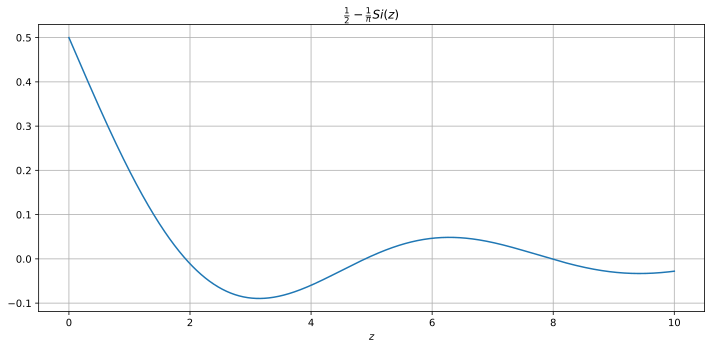

In [3]:
zs = np.linspace(0, 10, 1000)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(zs, 1 / 2 - 1 / np.pi * sc.special.sici(zs)[0])

ax.grid(True)
ax.set_xlabel('$z$')
ax.set_title(r'$\frac{1}{2} - \frac{1}{\pi}Si(z)$')
fig.tight_layout()
plt.show()

При $z = 0$ мы получаем поведение в точке разрыва — по теореме Дирихле сходимость ряда Фурье происходит точно к полусумме краевых значений. Однако, с увеличением $z$ невязка должна стремиться к нулю. Её отклонение в меньшую сторону, одначает что ряд Фурье "перескакивает" за истинное значение функции. Как следствие, нас будет интересовать первый экстремум выражения под модулем:
$$
\frac{d (\frac{1}{2} - \frac{1}{\pi}Si(z))}{dz} = 0 \iff z = \pi k \rightarrow max |\frac{1}{2} - \frac{1}{\pi}Si(z))| \approx 0.0895 
$$

Итого, получаем, что максимум невязки функции скачка и её ряда Фурье достигается в точке $z = \pi \iff t = \frac{T}{2N}$ и ошибка аппроксимации составляет $\frac{0.0895T}{T} \approx 9\%$. 

Для любого сигнала с конечным разрывом первого рода величиной $J$:
1.  Ряд Фурье не сходится равномерно в окрестности разрыва.
2.  Частичные суммы $S_N(t)$ образуют выброс (overshoot) непосредственно до и после скачка.
3.  При $N \to \infty$ ширина выброса стремится к нулю, но его амплитуда стремится к постоянной величине:
    $$ \Delta_{Gibbs} \approx 0.09 \cdot |J| $$
    То есть амплитуда "звона" всегда составляет **около 9% от величины полного скачка** функции в этой точке.

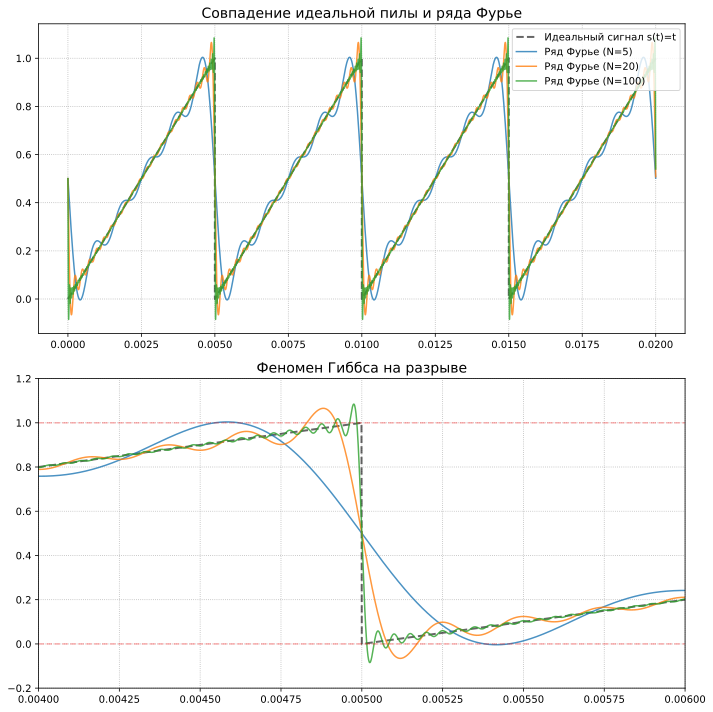

True signal


Gibbs error


Approximation, n=1


Approximation, n=5


Approximation, n=20


Approximation, n=100


In [4]:
def get_consistent_sawtooth(N, T, duration, sr):
    ts = np.linspace(0, duration, int(sr * duration), endpoint=False)
    
    reconstruction = np.zeros_like(ts)
    for n in range(1, N + 1):
        reconstruction += np.sin(n * 2 * np.pi / T * ts) / n
        
    return ts, 1 / 2 - (1.0 / np.pi) * reconstruction

T_period, duration, sr = 1.0 / 200, 0.02, 10 ** 6
ts_fine = np.linspace(0, duration, int(sr * duration), endpoint=False)
ideal_signal = (ts_fine % T_period) / T_period

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

ax1.plot(ts_fine, ideal_signal, 'k--', label='Идеальный сигнал s(t)=t', alpha=0.6, lw=2)
ax2.plot(ts_fine, ideal_signal, 'k--', alpha=0.6, lw=2)

for n, col in zip([5, 20, 100], ['#1f77b4', '#ff7f0e', '#2ca02c']):
    ts, reconstruction = get_consistent_sawtooth(n, T_period, duration, sr)
    ax1.plot(ts, reconstruction, label=f'Ряд Фурье (N={n})', color=col, alpha=0.8)
    ax2.plot(ts, reconstruction, color=col, alpha=0.8)

ax1.set_title('Совпадение идеальной пилы и ряда Фурье', fontsize=14)
ax1.legend(loc='upper right')
ax1.grid(True, ls=':')

ax2.set_xlim(T_period - 0.001, T_period + 0.001)
ax2.set_ylim(-0.2, 1.2)
ax2.set_title('Феномен Гиббса на разрыве', fontsize=14)
ax2.axhline(1.0, color='red', ls='--', alpha=0.3)
ax2.axhline(0.0, color='red', ls='--', alpha=0.3)
ax2.grid(True, ls=':')

plt.tight_layout()
plt.show()

duration, sr = 2.0, 44100

t_audio = np.linspace(0, duration, int(duration * sr), endpoint=False)
true_audio = (t_audio % T_period) / T_period
_, approx_audio = get_consistent_sawtooth(100, T_period, duration=duration, sr=sr)
diff_audio = true_audio - approx_audio
print('True signal')
display(Audio(true_audio, rate=sr))
print('Gibbs error')
display(Audio(diff_audio, rate=sr))    

for n in [1, 5, 20, 100]:
    _, sig_audio = get_consistent_sawtooth(n, T_period, duration=duration, sr=sr)
    audio_to_play = sig_audio - 0.5
    audio_to_play /= np.max(np.abs(audio_to_play))
    audio_to_play *= 0.5
    print(f'Approximation, n={n}')
    display(Audio(audio_to_play, rate=sr))

### `Дискретизация аналогового сигнала. Апертурный эффект`

Теперь, вернёмся к связи между аналоговым сигналом и его дискретным сужением:
$$
s_{d}(t) = s(t) * ш_{T}(t)
$$

Рассмотрим дискретизацию через "реальную" решётчатую функцию с прямоугольными импульсами.

Пусть:
*   $T$ — период наблюдения.
*   $N$ — число отсчетов.
*   $\Delta t = \frac{T}{N}$ — шаг дискретизации.
*   $\tau$ — ширина импульса меандра (время интегрирования одного отсчета), обычно $\tau \le \Delta t$.

Тогда, 
$$
s[n] = \frac{1}{\tau} \int_{t_n - \tau/2}^{t_n + \tau /2} s(t) \, dt \;,\; t_n = n \Delta t
$$

Разложение исходного сигнала в ряд Фурье: $s(t) = \sum_{n=-\infty}^{\infty} s_n e^{-j \frac{2\pi}{T} nt}$.

Подставим это в формулу для $s[n]$:
$$ s[n] = \frac{1}{\tau} \int_{t_n - \tau/2}^{t_n + \tau/2} \left( \sum_{k=-\infty}^{\infty} s_k e^{-j \frac{2\pi}{T} kt} \right) dt $$

Поменяем местами сумму и интеграл и вычислим интеграл для одной экспоненты:

$$
\int_{t_n - \tau/2}^{t_n + \tau/2} e^{-j \frac{2\pi}{T} kt} dt = ... = \tau e^{-j w_k t_n} \frac{sin(w_k\tau / 2)}{w_k \tau / 2} = \tau e^{-j w_k t_n} sinc(w_k\tau / 2) = \tau e^{-j w_k t_n} sinc(\pi\frac{k\tau}{T}), w_k = \frac{2\pi}{T}k
$$

Подставляя в исходное выражение:
$$
s[n] = \sum_{k=-\infty}^{\infty} s_k sinc(w_k \tau/2) e^{-jw_k t_n} =  \sum_{k=-\infty}^{\infty} \hat{s_k} e^{-jw_k t_n} = \hat{s}(t)
$$

Сравним это выражение с идеальной дискретизацией аналогового сигнала:
$$
s_{\text{ideal}}[n] = \sum_{k=-\infty}^{\infty} s_k e^{-j w_k t_n}
$$

Таким образом, неидеальная дискретизация, является идеальной дискретизацией **другого** аналогового сигнала, чьи коэффициенты ряда Фурье сглажены по частоте: 
$$
\hat{s_k} = s_{k} sinc(w_k \tau / 2)
$$

In [5]:
def plot_aperture(T=1.0, tau=0.25, N=20):
    ns = np.arange(1, N + 1)

    Sn = 1.0 / ns
    Sn_tilde = Sn *  np.sinc(ns * tau / T)

    fig, axes = plt.subplots(2, 1, figsize=(10, 8))
    axes[0].stem(ns, Sn, linefmt='C0-', markerfmt='C0o', label='Оригинальные $c_k$ (мгновенные)')
    axes[0].stem(ns, Sn_tilde, linefmt='C1-', markerfmt='C1s', label='Искаженные $\\tilde{c}_k$ (меандр $\\tau$)')

    ns_fine = np.linspace(0.7, N, 200)
    axes[0].plot(ns_fine, 1 / ns_fine * np.sinc(ns_fine * tau / T), 'r--', alpha=0.4, label='Огибающая Sinc')

    axes[1].plot(ns_fine, np.sinc(ns_fine * tau / T))

    axes[0].set_title(f'Апертурные искажения при дискретизации ($\\tau/T = {tau/T}$)')
    axes[1].set_title(f'$Sinc(w)$')
    axes[0].set_xlabel('Номер гармоники $k$')
    axes[0].set_ylabel('Амплитуда')
    axes[0].legend()
    axes[0].grid(True)
    axes[1].grid(True)
    fig.tight_layout()
    plt.show()
    
interact(plot_aperture);

interactive(children=(FloatSlider(value=1.0, description='T', max=3.0, min=-1.0), FloatSlider(value=0.25, desc…

Очевидно, что нули $Sinc(w)$ совпадают с нулями $sin(w)$. Из формы графика понятно, что:
1. Более высокие частоты подавляются сильнее в результате дискретизации
2. Частоты соответсвующие нулям $sin(w)$ теряются полностью
3. В зависимости от частоты дискретизации низкие частоты почти не меняются 

То есть дискретизация вызывает преобразование, которое можно назвать **Фильтр нижних частот**.

### `Zero-Order Hold`

Разберём пример. Положим:
* Частота дискретизации $\Delta f = 44100 Hz$
* Усреднение для дискретизации происходит по всему периоду отсчёта $\tau = \frac{1}{\Delta f} \approx 23 ms$

Первый ноль $Sinc(\frac{2\pi}{T}k\tau/2)$ находится при $\frac{2\pi}{T}k\tau / 2 = \pi \Rightarrow f_0 = \frac{k_0}{T} = \frac{1}{\tau} = 44100Hz$. То есть при таком подходе мы сохраняем все частоты, которые мы могли бы восстановить просто из условий Теоремы Котельникова!

Более того, из-за алиасинга, мы теряем информацию о частотах выше $\frac{f}{2} = 22050 Hz$ в любом случае.

Однако интересно понять, как сильно дискретизация влияет на низкие частоты. 

Коэффициент затухания можно записать как:
$$
A(f_k) = Sinc(\pi\frac{k\tau}{T}) = Sinc(\pi\frac{f_k}{f})
$$

Рассмотрим канонические случаи:
1. Низкие частоты: $f_k \approx 100Hz \Rightarrow A(f_k) \approx 0.9999 \Rightarrow L_{dB} = 20\log_{10}(\frac{A(f_k)}{1}) \approx 0dB$
2. Средние частоты: $f_k \approx 1kHz \Rightarrow A(f_k) \approx 0.9991 \Rightarrow L_{dB} \approx -0.008dB$
3. Граница слышимости: $f_k \approx 20kHz \Rightarrow A(f_k) \approx 0.695 \Rightarrow L_{dB} \approx -3.16dB$

Получаем, что если записать звук на компьютер и подать его на динамики без преобразований, мы услышим искажённую версию с "заваленными" частотами!

К счастью, в современном мире эта проблема решена за счет того, что аудио-чипы работают на частотах, в десятки раз превышающих слышимый порог.

### `Anti-aliassing effect` 

Но есть ли польза от дискретизации? Оказывается что есть!

Вспомним, что при вычислении ДФТ получающиеся коэффициенты смешивают зеркальные и кратные частоты:
$$
S[m] = \sum\limits_{r=-\infty}^{\infty} \hat{s_{m + rN}} = s_m sinc\big(\pi \frac{m\tau}{T}\big) + \sum\limits_{r\ne0} s_{m + rN} sinc\Big(\pi \frac{(m + rN)\tau}{T}\Big)
$$

Первое слагаемое в выражении для ДФТ спектра описывает полезный сигнал, тогда как второе слагаемое отвечает за паразитные хвосты-алиасинг.  

При этом, чем больше $\tau\frac{(m + rN)\tau}{T}$ тем сильнее подавляются паразитные частоты. Разберём на примере с видео сигналом.

Допустим мы снимаем на камеру быстро вращающийся вентилятор:
* Частота вращения $f_{s} = 2.2Hz \Rightarrow T \approx 0.45s$
* Частота дискретизации $f = 2Hz$ — два кадра в секунду
* Время экспозиции $\tau = 0.5s$ — совпадает с периодом дискретизации

При выполнении идеальной дискретизации ДФТ не может извлечь частоты выше частоты дискретизации, вместо этого появится паразитная частнота на $0.2Hz$ (также как и совпадающая с ней зеркальная на $1.8Hz$). Теперь, вместо быстро вращающегося вентилятора мы будем видеть медленно вращающийся.

При переходе к дискретизации с помощью меандра все частоты аналогового сигнала будут пропущены через фильтр низких частот, в частности, для несущей частоты:
$$
A(f_{s}) = |sinc(\pi \frac{f_{s}}{f})| \approx 0.0894 \Rightarrow L_{dB} \approx -21dB
$$

За те $0.5$ секунды, пока открыт затвор камеры, вентилятор успевает сделать $1.1$ оборота (один полный круг + еще $10\%$ круга). Целый круг «размазался» в равномерный серый фон. Видными остались только «лишние» $10\%$ движения.

In [6]:
from plt_utils import animate_antialiasing

HTML(animate_antialiasing().to_html5_video())

Внимательный читатель может спросить, а чем Motion Blur лучше чем алиасинг? C практической точки зрения:
* В аудио: Что вы предпочтете? Чтобы звук был чуть менее «ярким» (мягкое размытие sinc), или чтобы в музыке появились посторонние хрипы, которых не было в оригинале (алиасинг)?
* В видео: Что лучше? Немного размытые спицы колеса при движении (Motion Blur) или колесо, которое явно крутится назад, а на пиджаке диктора переливается радужный узор (Муар/Алиасинг)?

На практике алиасинга стараются избегать, так как это необратимое внесение ложной информации, тогда как дискретизация не теряет информацию, а только меняет её масштаб (за исключением нулей $Sinc$, которые, в прочем, на практике находятся дальше самой высокой полезной частоты).

## $l^2$ `(Неограниченные/апериодические дискретные сигналы). Дискретно-временное преобразование Фурье`

Во всех предыдущих случаях, спектр сигнала оказывался или конечным, или счётным. Однако, может ли спектр быть непрерывным? Чтобы ответить на этот вопрос перейдём к апериодическим дискретным сигналам.

Тут мы сталкиваемся с тем, что выписать тригонометрический базис данного пространства не представляется возможным — такие функции будут гарантированно квадратично неинтегрируемыми. Вместо этого сделаем следующий трюк. Рассмотрим последовательность вложенных в $l^{2}$ пространств $\mathbb{C}^{N}$.

Рассмотрим произвольный сигнал $s[n]$ из $\mathbb{C}^{N}$. Запишем его представление в виде Ряда Фурье (**синтез**) и обратное преобразование (**анализ**):
$$
s[n] = \frac{1}{\sqrt{N}} \sum\limits_{k=0}^{N-1} S[k] e^{-j\frac{2\pi}{N}nk}
$$
$$
S[k] = \frac{1}{\sqrt{N}} \sum\limits_{n=0}^{N-1} s[n] e^{j\frac{2\pi}{N}nk}
$$

Рассмотрим предельный переход $N \rightarrow \infty$. 

Положим $w_{k} = \frac{2\pi k}{N} \Rightarrow \Delta w = \frac{2\pi}{N}$

Получим формулу синтеза:
$$
s[n] = \sqrt{\frac{\Delta w}{2 \pi}} \sum\limits_{k=0}^{N-1} S[k] e^{-jw_{k}n} = \sum\limits_{k=0}^{N-1} \Bigg[\frac{S[k]}{\sqrt{\Delta w}\sqrt{2 \pi}}\Bigg] e^{-jw_{k}n} \Delta w
$$

Определим формально периодические функции $S(e^{jw}) = \frac{1}{\sqrt{2\pi}}\sum\limits_{n=-\infty}^{\infty} s[n] e^{jwn}$, $S_{N}(e^{jw}) = \frac{1}{\sqrt{2\pi}}\sum\limits_{n=0}^{N - 1} s[n] e^{jwn}$ — **ДВПФ (дискретно-временное преобразование Фурье)**. Это выражение означает, что функция задана не просто на произвольных значениях переменной, а на комплексной окружности и она имеет периодические свойства.

Сравнивая ДВПФ с формулой анализа можно заметить, что $S_{N}(e^{jw_{k}}) = \frac{1}{\sqrt{2\pi}}\sum\limits_{n=0}^{N-1} s[n] e^{jw_{k}n} = \sqrt{\frac{N}{2\pi}} S[k]$. То есть ДВПФ является непрерывным продолжением дискретного спектра конечного сигнала. И наоборот, спектр конечного сигнала определяется как дискретизация некого непрерывного спектра. Причём, чем больше отсчётом исходного сигнала мы рассматриваем, тем более точно ДФТ приближает истинный спектр "настоящего" апериодического сигнала.

Формально проинтегрируем данное выражение:
$$
\int\limits_{0}^{2\pi} S(e^{jw}) e^{-jwm}dw = \int\limits_{0}^{2\pi} \frac{1}{\sqrt{2\pi}}\sum\limits_{n=-\infty}^{\infty} s[n] e^{jwn} e^{-jwm}dw
$$

В предположении равномерной сходимости $S_{N}(e^{jw}) \overset{N \rightarrow \infty}{\longrightarrow} S(e^{jw})$ можно поменять суммирование и интегрирование:
$$
\int\limits_{0}^{2\pi} S(e^{jw}) e^{-jwm}dw = \frac{1}{\sqrt{2\pi}}\sum\limits_{n=-\infty}^{\infty} s[n] \int\limits_{0}^{2\pi} e^{jw(n - m)}dw = \begin{cases} \sqrt{2\pi} s[m],& n=m\\ 0,& n\ne m \end{cases}
$$

Итого получим формулу синтеза:
$$
s[n] = \frac{1}{\sqrt{2\pi}} \int\limits_{0}^{2\pi} S(e^{jw}) e^{-jwn}dw
$$

Внимательный читатель может спросить, когда в $l^{2}$ будет выполнена равномерная сходимость $S_{N}(e^{jw_{k}})$? 

1. Если $s[n]$ суммируемый по модулю, то сходимость очевидна
2. Можно отказаться от равномерной сходимости и ограничиться сходимостью в среднем: $\int_{0}^{2\pi}|S(e^{jw}) - S_{N}(e^{jw})|^{2}dw \overset{N \rightarrow \infty}\longrightarrow 0$. В таком случае спектр может быть разрывным.

Таким образом, мы установили связь между пространствами $L^{2}[a, b]$ и $l^{2}$:
1. Разложение в ряд Фурье сигнала из $L^{2}[a, b]$ возвращает дискретный бесконечный спектр
2. ДФПФ для сигнала из $l^{2}$ возвращает периодический спектр

<table style="border-collapse:collapse;border-spacing:0" class="tg"><thead><tr><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Signal</th><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Transformation</th><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Analysis</th><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Synthesis</th></tr></thead>
<tbody><tr><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Infinite discrete (aperiodic) $s[n] \in l^2$</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">DTFT (Discrete-Time Fourier Transform)</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">$$S(e^{j \omega}) = \frac{1}{\sqrt{2\pi}} \sum_{n=-\infty}^{\infty} s[n] e^{-j \omega n}$$</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:right;vertical-align:top;word-break:normal">$$s[n] = \frac{1}{\sqrt{2\pi}} \int_{0}^{2\pi} S(e^{j \omega}) e^{j \omega n} d\omega$$</td></tr></tbody></table>

Также как и раньше, произведение коэффициентов перед формулами должно быть $\frac{1}{2\pi}$, а знак минус в экспоненте может стоять ровно в одной из двух формул.

### $s[n] = \delta[n]$

Положим:
$$
s[n] = \begin{cases} 1, &n = 0 \\ 0, &n\ne 0\end{cases}
$$

Тогда:
$$
S(e^{jw}) = \frac{1}{\sqrt{2\pi}} e^{-jw0} = \frac{1}{\sqrt{2\pi}}
$$

То есть спектр бесконечно короткого импульса — это константа (белый шум). Все частоты присутствуют с равной амплитудой.

### $s[n] = \delta[n - k]$

$$
S(e^{jw}) = \frac{1}{\sqrt{2\pi}} e^{-jwn}
$$

Сдвиг во времени не меняет амплитуду спектра, но добавляет линейный набег фазы. Данное свойство очевидно верно для любого сдвинутого сигнала!

### `Boxcar function`

$$
s[n] = \begin{cases} 1, &|n| \le M \\ 0, &\text{othewise}\end{cases}
$$

$$
S(e^{jw}) = \frac{1}{\sqrt{2\pi}} \sum\limits_{n=-\infty}^{\infty} s[n]e^{-jwn} = \frac{1}{\sqrt{2\pi}} \sum\limits_{n=-M}^{M} e^{-jwn}
$$

По формуле геометрической прогрессии:
$$
S(e^{jw}) = \frac{1}{\sqrt{2\pi}} \sum\limits_{n=-M}^{M} (e^{-jw})^n = \frac{1}{\sqrt{2\pi}} \frac{e^{-jw(-M)} - e^{-jw(M+1)}}{1 - e^{-jw}} = \{\times e^{jw/2}\} = \frac{1}{\sqrt{2\pi}} \frac{e^{jw(M + 1/2)} - e^{-jw(M+1/2)}}{e^{jw/2} - e^{-jw/2}} = \frac{1}{\sqrt{2\pi}} \frac{sin((M + 1/2)w)}{sin(w/2)}
$$

Заметим: $N = 2M + 1$. Следовательно:
$$
S(e^{jw}) = \frac{1}{\sqrt{2\pi}} \frac{sin(Nw/2)}{sin(w/2)} = D_N(w)\;\textbf{-- Ядро Дирихле}
$$

Можно заметить сходство Ядра Дирихле с функцией $Sinc(w)$ — в районе нуля обе функции имеют одинаковое поведение, с точностью до константного множителя, однако, **Ядро Дирихле является периодическим аналогом** $Sinc(w)$.

Свойства Ядра Дирихле:
    
1. $\sqrt{2\pi} \lim\limits_{w\rightarrow 0} D_{N}(w) = \{\text{L'Hôpital's Rule}\} = N$
2. Ядро периодично с периодом $2\pi$
3. Нули совпадают с нулями синуса: $w_{k} = \frac{2\pi}{N}k$

<b style='color:red;'>Как будет выглядеть Ядро Дирихле для несимметричного сигнала, заданого от $0$ до $N - 1$</b>

<details><summary>Answer:</summary>>> В спектре появится фазовый множитель $e^{-jw\frac{N - 1}{2}}$ </details>

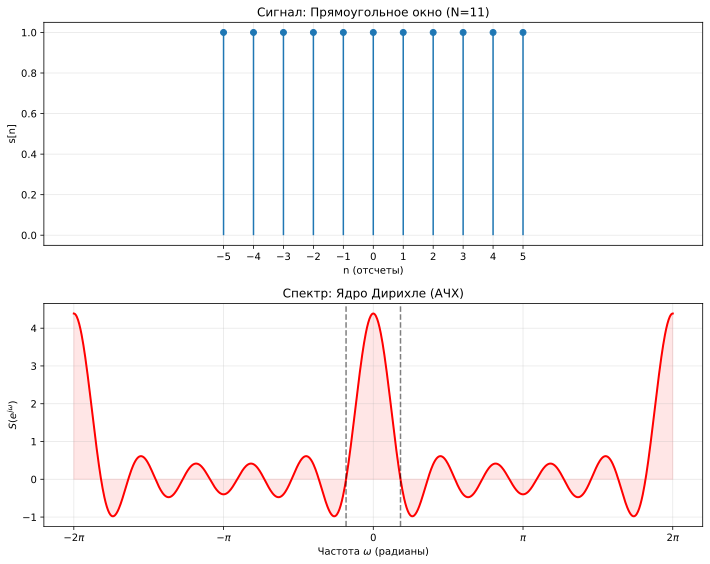

In [7]:
N = 11
M = (N - 1) // 2
n = np.arange(-M, M + 1)
w_n = np.ones(N)

omega = np.linspace(-2 * np.pi, 2 * np.pi, 1000)

with np.errstate(divide='ignore', invalid='ignore'):
    dirichlet = np.sin(N * omega / 2) / np.sin(omega / 2)
    dirichlet[omega == 0] = N
    dirichlet[np.isclose(np.sin(omega/2), 0)] = N * np.sign(np.cos(M * omega))[np.isclose(np.sin(omega/2), 0)]
    dirichlet /= np.sqrt(2 * np.pi)
    
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

ax1.stem(n, w_n, basefmt=" ")
ax1.set_title(f'Сигнал: Прямоугольное окно (N={N})')
ax1.set_xlabel('n (отсчеты)')
ax1.set_ylabel('s[n]')
ax1.set_xlim(-N, N)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(n)

ax2.plot(omega, dirichlet, 'r', lw=2, label=r'$D_N(\omega)$')
ax2.fill_between(omega, dirichlet, color='red', alpha=0.1)

ax2.set_title('Спектр: Ядро Дирихле (АЧХ)')
ax2.set_xlabel('Частота $\omega$ (радианы)')
ax2.set_ylabel('$S(e^{j\omega})$')
ax2.grid(True, alpha=0.3)

ticks = [-2*np.pi, -np.pi, 0, np.pi, 2*np.pi]
labels = [r'$-2\pi$', r'$-\pi$', '0', r'$\pi$', r'$2\pi$']
ax2.set_xticks(ticks)
ax2.set_xticklabels(labels)

ax2.axvline(2*np.pi/N, color='k', linestyle='--', alpha=0.5)
ax2.axvline(-2*np.pi/N, color='k', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### `Теорема о свёртке`

Аналогично предыдущим случаям, главный результат частотного анализа — теорема о свёртке!

**Определение (Линейная свертка):**
Для сигналов $f[n], g[n] \in l^2$ свертка определяется как:
$$h[n] = (f * g)[n] = \sum_{k=-\infty}^{\infty} f[k]g[n-k]$$

**Теорема:**
Если $h[n] = (f * g)[n]$, то его ДВПФ $H(e^{j\omega}) = \sqrt{2\pi} \cdot F(e^{j\omega}) \cdot G(e^{j\omega})$.

**Доказательство:**
Используем формулу анализа:
1. Запишем $Z(e^{j\omega})$:
   $$H(e^{j\omega}) = \frac{1}{\sqrt{2\pi}} \sum_{n=-\infty}^{\infty} \left( \sum_{k=-\infty}^{\infty} f[k]g[n-k] \right) e^{-j\omega n}$$
   

2. Меняем порядок суммирования:
   $$H(e^{j\omega}) = \frac{1}{\sqrt{2\pi}} \sum_{k=-\infty}^{\infty} f[k] \left( \sum_{n=-\infty}^{\infty} g[n-k] e^{-j\omega n} \right)$$

3. Введем замену во внутренней сумме: $m = n-k \Rightarrow n = m+k$:
   $$H(e^{j\omega}) = \frac{1}{\sqrt{2\pi}} \sum_{k} f[k] e^{-j\omega k} \sum_{m} g[m] e^{-j\omega m}$$

4. Заметим, что каждая сумма — это ДВПФ с точностью до множителя $\frac{1}{\sqrt{2\pi}}$.
   $$H(e^{j\omega}) = \sqrt{2\pi} F(e^{j\omega}) G(e^{j\omega}) \quad \blacksquare$$

Несложно показать и дуальную версию теоремы:
$$
h[n] = f[n]g[n] \iff H(e^{jw}) = \frac{1}{\sqrt{2\pi}}(F * G)(e^{jw})
$$

Можно заметить, что во всех трёх случаях ($\mathbb{C}^{N}, L^{2}[a, b], l^{2}$) структура Теоремы о Свёртке, так же как и её доказательство имеет одинаковую форму: 

**Спектр свертки = (Нормировочная константа) × Произведение спектров.**

<b style='color:red;'>А почему так происходит</b>

<details><summary>Answer:</summary>>> Ответ на этот вопрос оказывается неприлично сложным. Для всех интересующихся, ключевые слова, чтобы погрузиться: коммутативными группами сдвигов, Теорема Понтрягина, нормировки меры Хаара</details>

### `Растекание спектра`

[Всё ещё] внимательный слушатель может заметить, что в компьютерах бесконечных сигналов не существует и мы всегда работаем с конечным фрагментом бесконечного дискретного сигнала. Рассмотим как меняется спектр при ограничении окна.

Путь $s[n] \in l^{2}$. Переход от бесконечного сигнала к конечному эквивалентен умножению сигнала на оконную функцию:
$$
s_{w}[n] = s[n] w[n],\quad w[n] = \begin{cases} 1, & |n| \le M\\ 0, &\text{othewise} \end{cases}
$$

Чтобы найти спектр оконного сигнала, мы можем воспользоваться Теоремой о Свёртке и Ядром Дирихле. Заметим, что мы хотим вычислить спектр можно по **дуальной Теореме о Свёртке**:
$$
S_N(e^{jw}) = \frac{1}{\sqrt{2\pi}}\int\limits_{0}^{2\pi} S(e^{j\theta}) D_N(w - \theta) d\theta = \frac{1}{2\pi} \int_{0}^{2\pi} S(e^{j\theta}) \frac{\sin(N(\omega - \theta)/2)}{\sin((\omega - \theta)/2)} d\theta
$$

Данная формула показывает, что наблюдаемый спектр $S_N$ — это не истинный спектр $S$, а его «размытая» версия. Энергия из каждой частотной точки $\theta$ «растекается» по окрестности согласно форме ядра Дирихле.

Рассмотрим частный обобщённый случай. Здесь, мы формально возьмём периодический сигнал, который не лежит в l^{2}, однако данный пример крайне показателен.

Рассмотрим предельный случай, когда спектр задан только в одной точке:

Пусть $s[n] = e^{j\omega_0 n}$ (идеальный бесконечный тон). Его истинный спектр — дельта-функция: $S(e^{jw}) = \sqrt{2\pi} \delta(w - \omega_0)$.

Тогда наблюдаемый спектр:
$$S_N(e^{j\omega}) = \frac{1}{\sqrt{2\pi}} \int_{0}^{2\pi} \sqrt{2\pi} \delta(\theta - \omega_0) D_N(\omega - \theta) d\theta = D_N(\omega - \omega_0)$$

Вместо бесконечно узкой линии мы видим Ядро Дирихле с центром в $\omega_0$. 

В результате, для каждой спектральной полосы, ограниченный сигнал получит **два компонента «растекания»**:
1.  **Расширение основного лепестка (Main Lobe):**
    Ширина центрального пика ядра Дирихле составляет $\Delta \omega \approx \frac{4\pi}{N}$. Это означает, что любая спектральная особенность «размазывается» на эту величину. 
    *   *Следствие:* Если в сигнале есть две частоты $\omega_1$ и $\omega_2$, такие что $|\omega_1 - \omega_2| < \frac{2\pi}{N}$, их спектральные пики сольются, и мы не сможем их различить. **Растекание ограничивает разрешающую способность.**

2.  **Появление боковых лепестков (Side Lobes):**
    Ядро Дирихле имеет «хвосты», которые затухают очень медленно (как $1/\omega$). 
    *   *Следствие:* Энергия сильного сигнала на частоте $\omega_1$ через боковые лепестки «просачивается» на другие частоты. Если на частоте $\omega_2$ есть слабый сигнал, он будет полностью маскирован «растекшейся» энергией сильного сигнала.

Эффект растекания спектра — это прямое следствие **ограниченности времени наблюдения**. 

С точки зрения $l^2$:
*   Операция взятия окна — это проекция бесконечного сигнала на конечномерное подпространство. 
*   Поскольку прямоугольное окно имеет «резкие» края в весовой области, его Фурье-образ (Ядро Дирихле) имеет «длинные хвосты» в частотной области.

Рассмотрим произвольный сигнал $s[n]$ с конечным (дискретным) спектром $\{w_{n}\}$. Несмотря на то, что такой сигнал принадлежит $l^{\infty}$, а не $l^{2}$, можно формально рассмотреть ДФПФ продолжение спектра данного сигнала:
$$
S(e^{jw}) = \sqrt{2\pi}\sum\limits_{n=-\infty}^{\infty} S[n] \delta(w - w_n)
$$

Очевидно, что такой сигнал будет периодичен с неким периодом $P$: $w_{n} = \frac{2\pi}{P}n$.

Переходя обратно к сужению бесконечного периодического сигнала на произвольный интервал:
$$
s_N[n] = s[n] w_N[n] \Rightarrow S_{w}(e^{jw}) = \frac{1}{\sqrt{2\pi}} \int\limits_{0}^{2\pi}S(e^{j\theta})D_N(w - \theta)d\theta = \frac{1}{\sqrt{2\pi}} \int\limits_{0}^{2\pi} \Bigg[ \sqrt{2\pi} \sum\limits_{n=-\infty}^{\infty} S[n] \delta(\theta - w_n) \Bigg] D_N(w - \theta)d\theta
$$

Интегрируем, используя фильтрующее свойство $\delta$-функции:
$$
S_w(e^{jw}) = \sum\limits_{n=-\infty}^{\infty} S[n] D_N(w - w_n)
$$

Непрерывный спектр оконного сигнала — это сумма сдвинутых Ядер Дирихле. Каждая «идеальная» частота $w_n$ теперь окружена «ореолом» из боковых лепестков.

Таким образом, переход от периодического дискретного сигнала с конечным спектром к конечному сигналу вносит искажения связанные с ядром Дирихле. Сравним коэффициенты ДФТ сигнала $s_{N}[n]$ с его истинным спектром $S[n]$.

В случае ДФТ спектр задан на равномерной сетке: $\Omega_k = \frac{2\pi}{N}k$. Следовательно:
$$
S_N[k] = \sqrt{2\pi} S_{w}(e^{j\Omega_k}) = \sqrt{2\pi} \sum\limits_{n=-\infty}^{\infty} S[n] D_N(\Omega_k - w_n)
$$

**Итоговое влияние сужения сигнала будет зависеть от соотношения между узлами сетки $\Omega_k$ и частотами спектра исходного сигнала $w_n$.**

1. Случай "Целое число периодов", $N = m \times P$:

В данном случае $w_{n}$ в точности совпадает с одним из $\Omega_k$. Следовательно:
* В данной точке $S_N[k] = S[k]$.
* Аргумента Ядра Дирихле $\frac{N}{2}(\Omega_k - w_{k}) = \pi(k - nm)$ кратен $\pi$ и по всем отсчётам **Ядро Дирихле попало в свои нули**.

В результате, частота будет восстановлена корректно. Растекание отсутствует.

2. Случай "Нецелое число периодов"

Если $w_n$ находится между узлами сетки $\Omega_k, \Omega_{k+1}$:
* Аргумент Ядра Дирихле $\frac{N}{2}(\Omega_k - w_{k})$ никогда не кратен $\pi$.
* Числитель Ядра никогда не обращается в ноль, как следствие, гармоника $S[n]$ "протекла" во все бины спектра.

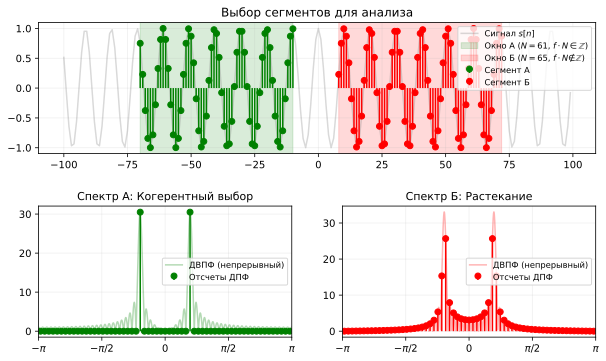

In [8]:
def dirichlet_kernel(omega, N):
    with np.errstate(divide='ignore', invalid='ignore'):
        val = np.sin(N * omega / 2) / np.sin(omega / 2)
    val[np.abs(np.remainder(omega + np.pi, 2 * np.pi) - np.pi) < 1e-10] = N
    return val / np.sqrt(2 * np.pi)

N1, N2 = 61, 65
M1, M2 = (N1 - 1) // 2, (N2 - 1) // 2

n_long = np.arange(-100, 100)
w0 = 2 * np.pi * 6 / 61 
s_long = np.cos(w0 * n_long)

center1, center2 = -40, 40
n1 = np.arange(center1 - M1, center1 + M1 + 1)
n2 = np.arange(center2 - M2, center2 + M2 + 1)

fig = plt.figure(figsize=(10, 9))
gs = plt.GridSpec(3, 2, hspace=0.4)

ax_time = fig.add_subplot(gs[0, :])
ax_time.plot(n_long, s_long, color='gray', alpha=0.3, label='Сигнал $s[n]$')
ax_time.axvspan(n1[0], n1[-1], color='green', alpha=0.15, label=f'Окно A ($N={N1}$, $f \cdot N \in \mathbb{{Z}}$)')
ax_time.axvspan(n2[0], n2[-1], color='red', alpha=0.15, label=f'Окно Б ($N={N2}$, $f \cdot N \\notin \mathbb{{Z}}$)')
ax_time.stem(n1, s_long[np.isin(n_long, n1)], linefmt='g-', markerfmt='go', basefmt=" ", label='Сегмент A')
ax_time.stem(n2, s_long[np.isin(n_long, n2)], linefmt='r-', markerfmt='ro', basefmt=" ", label='Сегмент Б')
ax_time.set_title("Выбор сегментов для анализа", fontsize=12)
ax_time.legend(loc='upper right', fontsize='small')
ax_time.grid(True, alpha=0.2)

omega_cont = np.linspace(-np.pi, np.pi, 2000)
def plot_spectrum(ax, N, color, title):
    S_cont = 0.5 * np.sqrt(2 * np.pi) * (
        dirichlet_kernel(omega_cont - w0, N) + 
        dirichlet_kernel(omega_cont + w0, N)
    )
    
    k = np.arange(-N // 2 + 1, N // 2 + 1)
    omega_dft = 2 * np.pi * k / N
    S_dft = 0.5 * np.sqrt(2 * np.pi) * (
        dirichlet_kernel(omega_dft - w0, N) + 
        dirichlet_kernel(omega_dft + w0, N)
    )
    
    ax.plot(omega_cont, np.abs(S_cont), color=color, alpha=0.3, label='ДВПФ (непрерывный)')
    ax.stem(omega_dft, np.abs(S_dft), linefmt=color, markerfmt='o', basefmt=" ", label='Отсчеты ДПФ')
    
    ax.set_title(title, fontsize=11)
    ax.set_xlim(-np.pi, np.pi)
    ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    ax.set_xticklabels(['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$'])
    ax.grid(True, alpha=0.2)
    ax.legend(fontsize='small')

plot_spectrum(fig.add_subplot(gs[1, 0]), N1, 'green', "Спектр A: Когерентный выбор")
plot_spectrum(fig.add_subplot(gs[1, 1]), N2, 'red', "Спектр Б: Растекание")

plt.show()

## `Вывод`

К данному моменту мы смогли определить периодические разложения для всех вариаций сигналов, кроме функций непрерывного аргумента определённых на неограниченном интервале.

## $L^{2}(\mathbb{R})$ `(Неограниченные/апериодические сигналы непрерывного аргумента). Интеграл Фурье`

Чтобы окончательно закрыть вопрос о дискретизации и точно понять как именно информация о непрерывных сигналах теряется, нужно перейти к описанию апереодических сигналов непрерывного аргумента. 

В качества модельного пространства таких сигналов можно рассмотреть $L^{2}(\mathbb{R})$. *Несмотря на то, что это в некотором смысле самое широкое функциональное пространство "нормальных" функций, которое можно рассмотреть без перехода к более сложной математике, оно не позволяет проводить обобщённый спектральный анализ периодических функций, поэтому не может являться финальной точкой нашего повествования.*

Чтобы перейти от ограниченных интервалов ко всей вещественной прямой, применим такой же трюк, что и в прошлой секции. Будем рассматривать апериодический сигнал $s(t)$ на $\mathbb{R}$ **с конечной продолжительностью** как предел периодического сигнала $s_{T}(t)$ на интервале $[0, T]$ при $T \rightarrow \infty$.

Знаем, что для достаточно "хорошего сигнала" $x_{T}(t)$ можно записать представление в виде Ряда Фурье (формула синтеза):
$$
s_{T}(t) = \frac{1}{\sqrt{T}} \sum\limits_{n=-\infty}^{\infty} s_{T, n} e^{-j\frac{2\pi}{T}nt}
$$

Запишем формулу анализа:

$$
s_{T, n} = \frac{1}{\sqrt{T}} \int\limits_{0}^{T} s_{T}(t) e^{j\frac{2\pi}{T}nt} dt = \frac{1}{\sqrt{T}} \int\limits_{0}^{T} s(t) e^{j\frac{2\pi}{T}nt} = \frac{1}{\sqrt{T}} \int\limits_{-\infty}^{\infty} s(t) e^{j\frac{2\pi}{T}nt} = \frac{1}{\sqrt{T}} \int\limits_{-\infty}^{\infty} s(t) e^{j\frac{2\pi}{T}nt} = \frac{1}{\sqrt{T}} S(n\Delta w)\quad,\quad\Delta w = \frac{2\pi}{T}
$$

Подставляя в исходную формулу:
$$
s_{T}(t) = \frac{1}{T} \sum\limits_{n=-\infty}^{\infty} S(n\Delta w)e^{-j\frac{2\pi}{T}nt} = \sum\limits_{n=-\infty}^{\infty} S(n\Delta w) \frac{\Delta w}{2\pi} e^{-jn\Delta w t} \Rightarrow s(t) = \lim_{T\rightarrow\infty} s_{T}(t) = \lim_{\Delta w\rightarrow 0} \sum\limits_{n=-\infty}^{\infty} S(n\Delta w) \frac{\Delta w}{2\pi} e^{-jn\Delta w t}
$$

При переходе к $T \rightarrow \infty$ сетка частот с интервалами $\Delta w \rightarrow 0$. Обозначим переменную частоты $n\Delta w = \Omega, \Delta \Omega = \Delta w$.

Предполагая, что $s(t)$ "достаточно хороший", получим переход к интегралу Лебега:
$$
s(t) = \frac{1}{2\pi} \int\limits_{-\infty}^{\infty} S(\Omega) e^{-j\Omega t} d\Omega
$$

Аналогично, для формулы анализа:
    
$$
S(\Omega) = \int\limits_{-\infty}^{\infty} s(t) e^{j\Omega t}dt
$$

Полученные интегралы описывают **Преобразование Фурье** в $L^{2}$ и задаются **Интегралами Фурье**.

<table style="border-collapse:collapse;border-spacing:0" class="tg"><thead><tr><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Signal</th><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Transformation</th><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Analysis</th><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Synthesis</th></tr></thead>
<tbody><tr><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Infinite (continuous support) $$s(t)\in L^{2}(\mathbb{R})$$</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Fourier Integral</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">$$S(\Omega) = \frac{1}{\sqrt{2\pi}} \int\limits_{-\infty}^{\infty} s(t) e^{-j\Omega t}dt$$</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:right;vertical-align:top;word-break:normal">$$s(t) = \frac{1}{\sqrt{2\pi}} \int\limits_{-\infty}^{\infty} S(\Omega) e^{j\Omega t} d\Omega$$</td></tr></tbody></table>

Также как и раньше, произведение коэффициентов перед формулами должно быть $\frac{1}{2\pi}$, а знак минус в экспоненте может стоять ровно в одной из двух формул.

Формулу анализа принято называть **Прямым Преобразованием Фурье** $\mathcal{F}$, тогда как формулу синтеза — **Обратное Преобразование Фурье** $\mathcal{F^{-1}}$.


Для краткости будем связь между сигналом и его спектором двусторонней стрелкой: **$s(t) \Longleftrightarrow S(\Omega)$**.

### `Критерии существования`

Критерии существования Интеграла Фурье записать в явном виде невозможно, но рассмотрим несколько достаточных условий:

1. **Средне-квадратичная сходимость**

Если $s(t) \in L^{2}(\mathbb{R})$, то есть $\int\limits_{-\infty}^{\infty} |s(t)|^{2}dt < \infty$, то:
* Интеграл Фурье сходится средне-квадратично в смысле несобственного интеграла.
* Гарантируется сходимости почти всюду (теорема Карлесона), то есть множество точек, где интеграл Фурье расходится, имеет меру ноль.

2. **Поточечная сходимость**

Если выполнены **Условия Дирихле**  $(1-3)$, то:
* Интеграл Фурье сходится поточечно, в том числе и в точках разрыва, где интеграл сойдется к среднему значению скачка

    1. $s(t)$ имеет конечное число разрывов первого рода
    2. $s(t)$ имеет конечное число экстремумов
    3. $s(t) \in L^{1}(\mathbb{R})$, то есть $\int\limits_{-\infty}^{\infty} |s(t)|dt < \infty$

Эти классы функций крайне ограничивают спектральный анализ. Для решения этой проблемы есть расширения с использованием функционального анализа!

### `Базовые свойства Преобразования Фурье`

Основной причиной использования формализма Преобразований Фурье — их разнообразные свойства, которые существенно упрощают подсчёт интегралов для большинства реальных сигналов и спекторов.

1. **Теорема обращения**

$$
\mathcal{F}^{-1}\{\mathcal{F}\{s(t)\}\} = s(t)
$$

2. **Дуальность/Инверсия времени**

$$
\mathcal{F}\{\mathcal{F}\{s(t)\}\} = s(-t)
$$

3. **Связь через комплексное сопряжение**

$$
\mathcal{F}^{-1}\{S(\Omega)\} = \mathcal{F}\{S^{*}(\Omega)\}^{*}
$$

4. **Равенство энергий (Теорема Планшереля - Парсеваля)**

$$
||s(t)||_{L^{2}} = ||S(\Omega)||_{L^{2}}
$$

*Строго говоря, для функций из $L^{2}$ это равенства $(1-3)$ выполняются «почти всюду» — во всех точках непрерывности сигнала.*

5. **Теорема изменения масштаба (Сжатие/Растяжение)**

Если ускорить или замедлить воспроизведение сигнала в $a \neq 0$ раз, то:
$$
s(at) \quad \Longleftrightarrow \quad \frac{1}{|a|} S\left(\frac{\Omega}{a}\right)
$$

* **Сжатие во времени ведет к расширению спектра** и наоборот. Если ускорить аудиозапись в $2$ раза, все частоты увеличатся в $2$ раза (спектр растянется), а общая амплитуда спектра упадет в $2$ раза (чтобы сохранить баланс энергии). Это фундаментальное проявление принципа неопределенности: нельзя локализовать сигнал одновременно и во времени, и по частоте.
* **Инверсия времени**
Если мы пустим сигнал задом наперед:
$$
s(-t) \quad \Longleftrightarrow \quad S(-\Omega)
$$

6. **Теорема запаздывания (Сдвиг во времени)**
Если мы задержим сигнал на время $t_0$:
$$s(t - t_0) \quad \Longleftrightarrow \quad S(\Omega) \cdot e^{-j\Omega t_0}$$
* Задержка сигнала во времени **никак не меняет его амплитудный спектр**. Она меняет только *фазовый спектр*, добавляя к нему линейный набег фазы $-\Omega t_0$. Все гармоники остаются теми же, они просто сдвигаются по фазе пропорционально их частоте.

7. **Теорема смещения (Сдвиг по частоте / Модуляция)**
Это свойство дуально предыдущему. Если мы умножим временной сигнал на комплексную гармонику с частотой $\Omega_0$:
$$
s(t) \cdot e^{j\Omega_0 t} \quad \Longleftrightarrow \quad S(\Omega - \Omega_0)
$$
* Умножая низкочастотный сигнал (например, голос) на высокочастотную несущую экспоненту, мы берем весь его спектр и целиком переносим (сдвигаем) на радиочастоту $\Omega_0$ для передачи через антенну.

8. **Дифференцирование во времени**
Скорость изменения сигнала:
$$
\frac{d}{dt}s(t) \quad \Longleftrightarrow \quad j\Omega \cdot S(\Omega)
$$
Каждая последующая производная просто добавляет еще один множитель: $s^{(n)}(t) \Leftrightarrow (j\Omega)^n S(\Omega)$.
* Дифференцирование работает как фильтр верхних частот. Оно усиливает высокие частоты (умножая их на большое $\Omega$) и подавляет постоянную составляющую ($\Omega = 0$).

9. **Умножение на аргумент (Дифференцирование по частоте)**
Умножение сигнала на время дает производную спектра:
$$
t \cdot s(t) \quad \Longleftrightarrow \quad j \frac{d}{d\Omega}S(\Omega)
$$

10. **Интегрирование во времени**
$$
\int\limits_{-\infty}^{t} s(\tau) d\tau \quad \Longleftrightarrow \quad \frac{S(\Omega)}{j\Omega} + \pi S(0)\delta(\Omega)
$$

* Деление на $j\Omega$ работает как интегратор / фильтр нижних частот. Второе слагаемое с дельта-функцией Дирака $\delta(\Omega)$ появляется, если у исходного сигнала была ненулевая постоянная составляющая $S(0)$, которая при интегрировании превращается в бесконечно растущую рампу).

11. **Теорема о свёртке**

Прохождение сигнала $s$ через систему с импульсной характеристикой $h$ описывается свёрткой:
$$
s(t) * h(t) \quad \Longleftrightarrow \quad \sqrt{2\pi} \cdot S(\Omega) \cdot H(\Omega)
$$
* Сложная интегральная операция свертки во времени превращается в **простое перемножение спектров**. Именно поэтому фильтры проектируют в частотной области!

12. **Перемножение во времени**

Если мы перемножим два сигнала во времени (например, при амплитудной модуляции или оконной фильтрации), их спектры свернутся:
$$
s_1(t) \cdot s_2(t) \quad \Longleftrightarrow \quad \frac{1}{\sqrt{2\pi}} \left[ S_1(\Omega) * S_2(\Omega) \right]
$$

### `Сравнение с другими простанствами`

Логичный вопрос который возникает, как переносятся указанные свойства на другие рассмотренные пространства. Прежде всего сравним формулы анализа-синтеза:

<table style="width: 100%; border-collapse: collapse; font-family: Arial, sans-serif; font-size: 14px;">
    <thead>
        <tr style="background-color: #f2f2f2; border-bottom: 2px solid #ddd;">
            <th style="border: 1px solid #ddd; padding: 12px; text-align: left;">Signal</th>
            <th style="border: 1px solid #ddd; padding: 12px; text-align: left;">Transformation</th>
            <th style="border: 1px solid #ddd; padding: 12px; text-align: center;">Analysis (Forward)</th>
            <th style="border: 1px solid #ddd; padding: 12px; text-align: center;">Synthesis (Inverse)</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td style="border: 1px solid #ddd; padding: 10px; vertical-align: middle;">
                <strong>Finite / Periodic</strong><br>Discrete support<br>
                $s[n] \in \mathbb{C}^{N}$
            </td>
            <td style="border: 1px solid #ddd; padding: 10px; vertical-align: middle;">
                <strong>DFT</strong>
            </td>
            <td style="border: 1px solid #ddd; padding: 10px; text-align: center; vertical-align: middle;">
                $$S[k] = \frac{1}{\sqrt{N}}\sum\limits_{n=0}^{N-1} s[n] e^{-j\frac{2\pi}{N}kn}$$
            </td>
            <td style="border: 1px solid #ddd; padding: 10px; text-align: center; vertical-align: middle;">
                $$s[n] = \frac{1}{\sqrt{N}}\sum\limits_{k=0}^{N-1} S[k] e^{j\frac{2\pi}{N}nk}$$
            </td>
        </tr>
        <tr style="background-color: #f9f9f9;">
            <td style="border: 1px solid #ddd; padding: 10px; vertical-align: middle;">
                <strong>Infinite / Aperiodic</strong><br>Discrete support<br>
                $s[n] \in l^2$
            </td>
            <td style="border: 1px solid #ddd; padding: 10px; vertical-align: middle;">
                <strong>DTFT</strong>
            </td>
            <td style="border: 1px solid #ddd; padding: 10px; text-align: center; vertical-align: middle;">
                $$S(e^{j \omega}) = \frac{1}{\sqrt{2\pi}} \sum_{n=-\infty}^{\infty} s[n] e^{-j \omega n}$$
            </td>
            <td style="border: 1px solid #ddd; padding: 10px; text-align: center; vertical-align: middle;">
                $$s[n] = \frac{1}{\sqrt{2\pi}} \int_{0}^{2\pi} S(e^{j \omega}) e^{j \omega n} d\omega$$
            </td>
        </tr>
        <tr>
            <td style="border: 1px solid #ddd; padding: 10px; vertical-align: middle;">
                <strong>Finite / Periodic</strong><br>Continuous support<br>
                $s(t)\in L^{2}[a, b]$
            </td>
            <td style="border: 1px solid #ddd; padding: 10px; vertical-align: middle;">
                <strong>Fourier Series</strong>
            </td>
            <td style="border: 1px solid #ddd; padding: 10px; text-align: center; vertical-align: middle;">
                $$S_n = \frac{1}{\sqrt{T}} \int_a^b s(t) e^{-j \frac{2\pi}{T}nt} \, dt$$
            </td>
            <td style="border: 1px solid #ddd; padding: 10px; text-align: center; vertical-align: middle;">
                $$s(t) = \frac{1}{\sqrt{T}} \sum_{n=-\infty}^{\infty} S_n e^{j \frac{2\pi}{T}nt}$$
            </td>
        </tr>
        <tr style="background-color: #f9f9f9;">
            <td style="border: 1px solid #ddd; padding: 10px; vertical-align: middle;">
                <strong>Infinite / Aperiodic</strong><br>Continuous support<br>
                $s(t)\in L^{2}(\mathbb{R})$
            </td>
            <td style="border: 1px solid #ddd; padding: 10px; vertical-align: middle;">
                <strong>Fourier Integral</strong>
            </td>
            <td style="border: 1px solid #ddd; padding: 10px; text-align: center; vertical-align: middle;">
                $$S(\Omega) = \frac{1}{\sqrt{2\pi}} \int\limits_{-\infty}^{\infty} s(t) e^{-j\Omega t}dt$$
            </td>
            <td style="border: 1px solid #ddd; padding: 10px; text-align: center; vertical-align: middle;">
                $$s(t) = \frac{1}{\sqrt{2\pi}} \int\limits_{-\infty}^{\infty} S(\Omega) e^{j\Omega t} d\Omega$$
            </td>
        </tr>
    </tbody>
</table>

Несмотря на внешнюю схожесть формул, логичный вопрос заключается в том, насколько совпадают свойства данных преобразований:

<table style="width: 100%; border-collapse: collapse; font-family: sans-serif;">
  <thead>
    <tr style="background-color: #f8f9fa;">
      <th style="border: 1px solid #dee2e6; padding: 12px; text-align: left; vertical-align: middle;">Свойство</th>
      <th style="border: 1px solid #dee2e6; padding: 12px; text-align: center; vertical-align: middle;">Интеграл Фурье</th>
      <th style="border: 1px solid #dee2e6; padding: 12px; text-align: center; vertical-align: middle;">Ряд Фурье</th>
      <th style="border: 1px solid #dee2e6; padding: 12px; text-align: center; vertical-align: middle;">ДВПФ</th>
      <th style="border: 1px solid #dee2e6; padding: 12px; text-align: center; vertical-align: middle;">ДПФ</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: left; vertical-align: middle;"><strong>Пространства</strong></td>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: center; vertical-align: middle;">$L^2(\mathbb{R}) \Longleftrightarrow L^2(\mathbb{R})$</td>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: center; vertical-align: middle;">$L^2[0, 2\pi] \Longleftrightarrow l^2(\mathbb{Z})$</td>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: center; vertical-align: middle;">$l^2(\mathbb{Z}) \Longleftrightarrow L^2[0, 2\pi]$</td>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: center; vertical-align: middle;">$\mathbb{C}^N \Longleftrightarrow \mathbb{C}^N$</td>
    </tr>
    <tr style="background-color: #fdfdfd;">
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: left; vertical-align: middle;"><strong>Линейность</strong></td>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: center; vertical-align: middle;">$a x_1(t) + b x_2(t)$<br>$\Longleftrightarrow$<br>$a X_1(\Omega) + b X_2(\Omega)$</td>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: center; vertical-align: middle;">$a x_1(t) + b x_2(t)$<br>$\Longleftrightarrow$<br>$a X_{1,k} + b X_{2,k}$</td>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: center; vertical-align: middle;">$a x_1[n] + b x_2[n]$<br>$\Longleftrightarrow$<br>$a X_1(\omega) + b X_2(\omega)$</td>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: center; vertical-align: middle;">$a x_1[n] + b x_2[n]$<br>$\Longleftrightarrow$<br>$a X_1[k] + b X_2[k]$</td>
    </tr>
    <tr>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: left; vertical-align: middle;"><strong>Сдвиг во времени</strong><br><span style="font-size: 0.85em; color: #555;">(Запаздывание)</span></td>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: center; vertical-align: middle;">$x(t - t_0)$<br>$\Longleftrightarrow$<br>$X(\Omega) e^{-j\Omega t_0}$</td>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: center; vertical-align: middle;">$x(t - t_0)$<br>$\Longleftrightarrow$<br>$X_k e^{-j k t_0}$</td>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: center; vertical-align: middle;">$x[n - m]$<br>$\Longleftrightarrow$<br>$X(\omega) e^{-j\omega m}$</td>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: center; vertical-align: middle;"><strong>Циклический:</strong><br>$x[(n - m) \bmod N]$<br>$\Longleftrightarrow$<br>$X[k] e^{-j \frac{2\pi}{N} k m}$</td>
    </tr>
    <tr style="background-color: #fdfdfd;">
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: left; vertical-align: middle;"><strong>Сдвиг по частоте</strong><br><span style="font-size: 0.85em; color: #555;">(Модуляция)</span></td>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: center; vertical-align: middle;">$x(t) e^{j\Omega_0 t}$<br>$\Longleftrightarrow$<br>$X(\Omega - \Omega_0)$</td>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: center; vertical-align: middle;">$x(t) e^{j m t}$<br>$\Longleftrightarrow$<br>$X_{k - m}$</td>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: center; vertical-align: middle;">$x[n] e^{j\omega_0 n}$<br>$\Longleftrightarrow$<br>$X(\omega - \omega_0)$</td>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: center; vertical-align: middle;">$x[n] e^{j \frac{2\pi}{N} m n}$<br>$\Longleftrightarrow$<br><strong>Цикл. сдвиг спектра:</strong><br>$X[(k - m) \bmod N]$</td>
    </tr>
    <tr>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: left; vertical-align: middle;"><strong>Свёртка</strong><br><span style="font-size: 0.85em; color: #555;">(Фильтрация)</span></td>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: center; vertical-align: middle;"><strong>Линейная:</strong><br>$x_1(t) * x_2(t)$<br>$\Longleftrightarrow$<br>$\sqrt{2\pi} X_1(\Omega) X_2(\Omega)$</td>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: center; vertical-align: middle;"><strong>Периодическая:</strong><br>$x_1(t) * x_2(t)$<br>$\Longleftrightarrow$<br>$\sqrt{2\pi} X_{1,k} X_{2,k}$</td>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: center; vertical-align: middle;"><strong>Линейная дискретн.:</strong><br>$x_1[n] * x_2[n]$<br>$\Longleftrightarrow$<br>$\sqrt{2\pi} X_1(\omega) X_2(\omega)$</td>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: center; vertical-align: middle;"><strong>Циклическая:</strong><br>$x_1[n] \circledast x_2[n]$<br>$\Longleftrightarrow$<br>$\sqrt{N} X_1[k] X_2[k]$</td>
    </tr>
    <tr style="background-color: #fdfdfd;">
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: left; vertical-align: middle;"><strong>Умножение</strong><br><span style="font-size: 0.85em; color: #555;">(Оконная обработка)</span></td>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: center; vertical-align: middle;">$x_1(t) x_2(t)$<br>$\Longleftrightarrow$<br>$\frac{1}{\sqrt{2\pi}} [X_1(\Omega) * X_2(\Omega)]$</td>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: center; vertical-align: middle;">$x_1(t) x_2(t)$<br>$\Longleftrightarrow$<br>$\frac{1}{\sqrt{2\pi}} [X_{1,k} * X_{2,k}]$</td>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: center; vertical-align: middle;">$x_1[n] x_2[n]$<br>$\Longleftrightarrow$<br>$\frac{1}{\sqrt{2\pi}} [X_1(\omega) \circledast X_2(\omega)]$</td>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: center; vertical-align: middle;">$x_1[n] x_2[n]$<br>$\Longleftrightarrow$<br>$\frac{1}{\sqrt{N}} [X_1[k] \circledast X_2[k]]$</td>
    </tr>
    <tr>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: left; vertical-align: middle;"><strong>Производная</strong><br><span style="font-size: 0.85em; color: #555;">(Во времени)</span></td>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: center; vertical-align: middle;">$\frac{d}{dt}x(t)$<br>$\Longleftrightarrow$<br>$j\Omega X(\Omega)$</td>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: center; vertical-align: middle;">$\frac{d}{dt}x(t)$<br>$\Longleftrightarrow$<br>$jk X_k$</td>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: center; vertical-align: middle;"><strong>Конечная разность:</strong><br>$x[n] - x[n-1]$<br>$\Longleftrightarrow$<br>$(1 - e^{-j\omega}) X(\omega)$</td>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: center; vertical-align: middle;"><strong>Циклич. разность:</strong><br>$x[n] - x[(n-1)\bmod N]$<br>$\Longleftrightarrow$<br>$(1 - e^{-j \frac{2\pi}{N} k}) X[k]$</td>
    </tr>
    <tr style="background-color: #fdfdfd;">
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: left; vertical-align: middle;"><strong>Производная</strong><br><span style="font-size: 0.85em; color: #555;">(По частоте)</span></td>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: center; vertical-align: middle;">$-jt x(t)$<br>$\Longleftrightarrow$<br>$\frac{d}{d\Omega}X(\Omega)$</td>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: center; vertical-align: middle; color: #777;">—<br><span style="font-size: 0.85em;">(Спектр дискретный)</span></td>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: center; vertical-align: middle;">$-jn x[n]$<br>$\Longleftrightarrow$<br>$\frac{d}{d\omega}X(\omega)$</td>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: center; vertical-align: middle; color: #777;">—<br><span style="font-size: 0.85em;">(Спектр дискретный)</span></td>
    </tr>
    <tr>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: left; vertical-align: middle;"><strong>Масштабирование</strong><br><span style="font-size: 0.85em; color: #555;">(Сжатие/Растяжение)</span></td>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: center; vertical-align: middle;">$x(at)$<br>$\Longleftrightarrow$<br>$\frac{1}{|a|} X\left(\frac{\Omega}{a}\right)$</td>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: center; vertical-align: middle; color: #777;">—<br><span style="font-size: 0.85em;">(Сжатие меняет период, выводит из $L^2[0,2\pi]$)</span></td>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: center; vertical-align: middle; color: #777;">—<br><span style="font-size: 0.85em;">(Только прореживание $x[Mn]$)</span></td>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: center; vertical-align: middle; color: #777;">—<br><span style="font-size: 0.85em;">(Дробных индексов нет)</span></td>
    </tr>
    <tr style="background-color: #fdfdfd;">
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: left; vertical-align: middle;"><strong>Теорема Парсеваля</strong><br><span style="font-size: 0.85em; color: #555;">(Энергия)</span></td>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: center; vertical-align: middle;">$\int\limits_{-\infty}^{\infty} |x(t)|^2 dt =$ <br> $\int\limits_{-\infty}^{\infty} |X(\Omega)|^2 d\Omega$</td>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: center; vertical-align: middle;">$\int\limits_{0}^{2\pi} |x(t)|^2 dt =$ <br> $\sum\limits_{k=-\infty}^{\infty} |X_k|^2$</td>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: center; vertical-align: middle;">$\sum\limits_{n=-\infty}^{\infty} |x[n]|^2 =$ <br> $\int\limits_{0}^{2\pi} |X(\omega)|^2 d\omega$</td>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: center; vertical-align: middle;">$\sum\limits_{n=0}^{N-1} |x[n]|^2 =$ <br> $\sum\limits_{k=0}^{N-1} |X[k]|^2$</td>
    </tr>
    <tr>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: left; vertical-align: middle;"><strong>Дуальность</strong><br><span style="font-size: 0.85em; color: #555;">(Симметрия)</span></td>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: center; vertical-align: middle;"><strong>Самодуально:</strong><br>$X(t) \Longleftrightarrow x(-\Omega)$</td>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: center; vertical-align: middle;"><strong>Дуально с ДВПФ:</strong><br>Из $x(t) \Longleftrightarrow X_k$<br>следует $X(t) \Longleftrightarrow x_{-k}$</td>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: center; vertical-align: middle;"><strong>Дуально с Рядом:</strong><br>Из $x[n] \Longleftrightarrow X(\omega)$<br>следует $X[n] \Longleftrightarrow x(-\omega)$</td>
      <td style="border: 1px solid #dee2e6; padding: 10px; text-align: center; vertical-align: middle;"><strong>Самодуально:</strong><br>$X[n] \Longleftrightarrow x[(-k) \bmod N]$</td>
    </tr>
  </tbody>
</table>

### `Прямоугольный импульс`

Пусть сигнал $s(t)$ равен амплитуде $A$ на симметричном интервале от $-\tau/2$ до $\tau/2$, и нулю в остальное время:
$$s(t) = \begin{cases} A, & |t| \le \tau/2 \\ 0, & |t| > \tau/2 \end{cases}$$

Пределы интегрирования сужаются до ширины импульса:
$$
S(\Omega) = \frac{1}{\sqrt{2\pi}}\int_{-\tau/2}^{\tau/2} A \cdot e^{-j\Omega t} dt = \frac{A}{\sqrt{2\pi}} \left[ \frac{e^{-j\Omega t}}{-j\Omega} \right]_{-\tau/2}^{\tau/2}
$$

Подставляем пределы и используем формулу Эйлера $\sin(x) = \frac{e^{jx} - e^{-jx}}{2j}$:
$$
S(\Omega) = \frac{A}{-j\Omega\sqrt{2\pi}} \left( e^{-j\Omega \frac{\tau}{2}} - e^{j\Omega \frac{\tau}{2}} \right) = \frac{A}{\sqrt{2\pi}\Omega} \cdot \frac{e^{j\Omega \frac{\tau}{2}} - e^{-j\Omega \frac{\tau}{2}}}{j} = \frac{2A}{\sqrt{2\pi}\Omega} \sin\left(\Omega \frac{\tau}{2}\right)
$$

Умножив числитель и знаменатель на $\tau$, приводим к классическому виду функции $\text{sinc}(x) = \frac{\sin x}{x}$:
$$
S(\Omega) = \frac{A\tau}{\sqrt{2\pi}} \cdot \frac{\sin(\Omega \tau / 2)}{\Omega \tau / 2} = \frac{A\tau}{\sqrt{2\pi}} \cdot \text{sinc}\left(\frac{\Omega \tau}{2}\right)
$$

$$s(t) = \begin{cases} A, & |t| \le \tau/2 \\ 0, & |t| > \tau/2 \end{cases} \overset{\mathcal{F}}{\longrightarrow} \frac{A\tau}{\sqrt{2\pi}} \cdot \text{sinc}\left(\frac{\Omega \tau}{2}\right) = S(\Omega)$$

### $s(t) = sinc(\Omega_c t)$

Допустим, временной сигнал задан: 
$$s(t) = \frac{\sin(\Omega_c t)}{\Omega_c t},$$
где $\Omega_c$ — некоторая граничная частота.

Если мы проверим эту функцию на принадлежность к $L^1$, мы обнаружим проблему. Интеграл от модуля этой функции расходится: 
$$
\int_{-\infty}^{\infty} \left| \frac{\sin(\Omega_c t)}{\Omega_c t} \right| dt = \infty
$$

То есть, **$\text{sinc}(\Omega_c t)$ не является абсолютно интегрируемой функцией**. Классический интеграл Лебега от неё формально не существует! 

Однако энергия этого сигнала конечна: 
$$
\int_{-\infty}^{\infty} \left( \frac{\sin(\Omega_c t)}{\Omega_c t} \right)^2 dt < \infty,
$$ 
то есть $s(t) \in L^2(\mathbb{R})$. 

Как следствие, **интеграл данной функции будет сходиться в средне-квадратичном смысле.**

Считать Интеграл Фурье "в лоб" через теорию вычетов можно, но это громоздко. 

Вместо этого применим свойство **дуальности** Преобразования Фурье.
Из предыдущего примера знаем, что $\text{Прямоугольный импульс} \xrightarrow{\mathcal{F}} sinc$.

Из свойства дуальности следует, что если мы поменяем время и частоту местами, то $sinc \xrightarrow{\mathcal{F}} 
\text{Прямоугольный импульс}$

Более точно:

$$s(t) = \begin{cases} A, & |t| \le \tau/2 \\ 0, & |t| > \tau/2 \end{cases} \overset{\mathcal{F}}{\longrightarrow} \frac{A\tau}{\sqrt{2\pi}} \cdot \text{sinc}\left(\frac{\Omega \tau}{2}\right) \overset{\mathcal{F}}{\longrightarrow} = s(-t)$$

Делая замену переменных, полагая, что $\frac{A\tau}{\sqrt{2\pi}} = 1, \frac{\Omega \tau}{2} = \Omega \Omega_c$:

Спектр будет иметь вид прямоугольной функции в частотной области:
$$
S(\Omega) = \begin{cases} \frac{\sqrt{2\pi}}{2A\Omega_c}, & |\Omega| \le \Omega_c \\ 0, & |\Omega| > \Omega_c \end{cases}
$$

### $s(t) = e^{-at^2}, a > 0.$ `Гауссов импульс`

Данная функция бесконечно дифференцируема, убывает быстрее любой экспоненты, лежит во всех возможных пространствах ($L^1, L^2, L^p$).

$$
S(\Omega) = \frac{1}{\sqrt{2\pi}}\int_{-\infty}^{\infty} e^{-at^2} e^{-j\Omega t} dt =  \frac{1}{\sqrt{2\pi}}\int_{-\infty}^{\infty} e^{-(at^2 + j\Omega t)} dt
$$

Выделим полный квадрат в показателе степени:
$$
at^2 + j\Omega t = a\left(t^2 + \frac{j\Omega}{a}t\right) = a\left(t + \frac{j\Omega}{2a}\right)^2 - a\left(\frac{j\Omega}{2a}\right)^2 = a\left(t + \frac{j\Omega}{2a}\right)^2 + \frac{\Omega^2}{4a}
$$

Подставляем обратно в интеграл:
$$
S(\Omega) =  \frac{1}{\sqrt{2\pi}} e^{-\frac{\Omega^2}{4a}} \int_{-\infty}^{\infty} e^{-a\left(t + \frac{j\Omega}{2a}\right)^2} dt
$$

Оставшийся интеграл через замену переменных сводится к классическому интегралу Пуассона:
$$
\int_{-\infty}^{\infty} e^{-ax^2} dx = \sqrt{\frac{\pi}{a}}
$$

В итоге:
$$
S(\Omega) = \frac{1}{\sqrt{2a}} \cdot e^{-\frac{\Omega^2}{4a}}
$$

Преобразование Фурье от Гауссианы — это снова Гауссиана! Форма сигнала не поменялась.

## `Обобщённое Преобразование Фурье`

Остался последний вопрос, а что же делать с сигналами, которые не интегрируемы в $L^{2}$ (например, постоянная единица, функция Хевисайда или гармоника).

Попробуем подойти к вопросу о существовании Преобразования Фурье не через его формальный интегральный вид, а через его **функциональные свойства**.

Из всех свойств Преобразования Фурье важнейшим являются:
1. **Линейность:** 
$$
\mathcal{F}\{a \cdot s_1(t) + b \cdot s_2(t)\} = a\mathcal{F}\{s_1(t)\} + b\mathcal{F}\{s_2(t)\}
$$
2. **Дуальность дифференцирования и умножения:**
    * Перевод дифференцирования в умножение: $\mathcal{F}\{s'(t)\} = j\Omega \cdot \mathcal{F}\{s(t)\}$
    * Перевод умножения в дифференцирование: $\mathcal{F}\{t \cdot s(t)\} = j \cdot \frac{d}{d\Omega}\mathcal{F}\{s(t)\}$
3. **Теорема о свёртке**
$$
\mathcal{F}\{(s_{1} * s_{2})(t)\} \propto \mathcal{F}\{s_{1}(t)\} \cdot \mathcal{F}\{s_{2}(t)\}
$$

**Оказывается существует единственный (с точностью до изоморфизма) линейный непрерывный оператор $\mathcal{F}$, который удовлетворяет свойству $2$!**

**Более того, существует единственный (с точностью до изоморфизма) линейный непрерывный оператор $\mathcal{F}$, который удовлетворяет свойству $3$!**

Как следствие, в качестве представления Преобразования Фурье, можно взять, например, любую из форм Интеграла Фурье.

Однако, это представление не помогает нам вычислять преобразование для "плохих" функций.

Ключевой переход для задания **Обобщённого Преобразования Фурье** заключается в возможности анализировать результат **Обобщённого Преобразования Фурье** сигнала $s(t)$, через его влияние на его действие на пробные функции.

### `Определение через сопряжение. Пространство пробных функций (Простнанство Шварца. Tempered Distributions)`

Будем называть $\mathcal{F}\{s\}$ — **Преобразованием Фурье** для сигнала $s(t)$, если:
$$
\langle \mathcal{F}\{s\}, \phi \rangle = \langle s, \mathcal{F}\{\phi\} \rangle,\;\forall\;\phi \in \mathcal{S}
$$

Где множество функций $\mathcal{S}$ — это множество "хороших", **пробных функций**, для которых Интеграл/Преобразование Фурье существует в обычном смысле.

Выбор правильного класса **пробных функций** — нетривиальная задача. Интуитивно хочется, чтобы Преобразование Фурье в итоге не выводило функции из этого класса, то есть замкнутость относительно целевого преобразования. Для нашей задачи классическим выбором является **Пространство Шварца $\mathcal{S}$** (функции быстрого убывания):

$\phi(t) \in \mathcal{S}$, если:
1. $\phi(t) \in \mathcal{С}^{\infty}$
2. Все производные $\phi(t)$ убывают быстрее любой обратной степени $t$, то есть $\forall\;n,m \in \mathbb{N} \Rightarrow |t^{n}\partial^{m} \phi(t)| \overset{t \rightarrow \infty}{\longrightarrow} 0$

Примером функции Шварца является, например, $e^{-t^{2}}$. Также, очевидно, что произведение многочлена на функцию Шварца оставляет результат в том же классе функций.

Так как $\mathcal{S} \subset L^{2}$, то Преобразование Фурье переводит пространство Шварца само в себя, что позволяет нам не беспокоиться о сходимости интегралов.

Очень внимательный читатель обязан задать два вопроса:
1. Почему определение через сопряжение будет самосогласованным с определением через Интеграл Фурье?
2. Будут ли переноситься свойства Интеграла Фурье на Обобщённое Преобразование Фурье?

Ответ на оба эти вопроса — да! **Докажите это сами!**

Попробуем применить Обобщённое Преобразование Фурье к реальным функциям:

### `Константа. Дельта-функция`

Рассмотрим простейшую неинтегрируемую функцию $s(t) = 1$. По определению:
$$
\langle \mathcal{F}\{1\}, \phi \rangle = \langle 1, \mathcal{F}\{\phi \} \rangle = \int\limits_{-\infty}^{\infty} \mathcal{F}\{\phi\}(t)dt
$$

Из формулы синтеза для произвольной функции:
$$
\phi(\Omega) = \frac{1}{\sqrt{2\pi}} \int\limits_{-\infty}^{\infty} \mathcal{F}\{\phi\}(t) e^{j\Omega t}dt \Longrightarrow \phi(0) = \frac{1}{\sqrt{2\pi}} \int\limits_{-\infty}^{\infty} \mathcal{F}\{\phi\}(t) dt
$$

Подставляя в исходное выражение:
$$
\langle \mathcal{F}\{1\}, \phi \rangle = \sqrt{2\pi} \phi(0)
$$

То есть, Обобщённое Преобразовае Фурье для константы должно "вырезать" одно значение из непрерывной функции. Среди обычных функций таких нет. Поэтому нам необходимо расширить пространство функций добавив в него новую функцию, которую называют $\delta-$функция:
$$
\langle \delta(t), \phi(t) \rangle = \phi(0)\;\forall\;\phi\in S
$$

Итого, получаем, фундаментальную связь:
$$
1 \Longleftrightarrow \sqrt{2\pi} \delta(\Omega)
$$

Можно интерпретировать дельта-функцию, как единичный всплеск в нуле с бесконечной амплитудой. 

### `Функция Хевисайда`

Рассмотрим бесконечный единичный скачок:
    
$$
\sigma(t) = \begin{cases} 1, &t \ge 0\\ 0, &t < 0\end{cases}
$$

Заметим, что 
$$
\langle \sigma^{\prime}, \phi \rangle = \sigma(t)\phi(t)\Bigg|^{\infty}_{-\infty} - \langle \sigma, \phi^{\prime} \rangle = - \langle \sigma, \phi^{\prime} \rangle = -\int\limits_{0}^{\infty} \phi^{\prime}(t) dt = -\phi(t)\Bigg|^{\infty}_{0} = \phi(0) \Longrightarrow \sigma^{\prime}(t) = \delta(t)
$$

Тогда, по свойству дифференцирования:
$$
\mathcal{F}\{\sigma^{\prime}\} = \mathcal{F}\{\delta\} \Longrightarrow j\Omega S(\Omega) = \frac{1}{\sqrt{2\pi}} \Longrightarrow \{xF(x) = 1 \iff F(x) = 1 / x + C \delta(x) \} \Longrightarrow S(\Omega) = \frac{1}{j\Omega\sqrt{2\pi}} + C\delta(\Omega)
$$

Чтобы найти константу, рассмотрим значение сигнала в нуле, через формулу анализа. По условиям Дирихле, мы гарантируем сходимость в точке разрыва к полусумме пределов:
$$
s(0) = \frac{1}{2} = \frac{1}{\sqrt{2\pi}} \int\limits^{\infty}_{-\infty} \Bigg(\frac{1}{j\Omega\sqrt{2\pi}} + C\delta(\Omega)\Bigg) d\Omega =\\ = \{ \text{по определению, деление в обобщённых функциях понимается в смысле главного значения} \} = \frac{С}{\sqrt{2\pi}} \Longrightarrow C = \sqrt{\frac{\pi}{2}}
$$

Итого:

$$
\sigma(t) \Longleftrightarrow \sqrt{\frac{\pi}{2}} \delta(\Omega) + \frac{1}{j\sqrt{2\pi}} PV\frac{1}{\Omega}
$$

Гипербола в спектре отвечает за сам факт «прыжка» функции, но она не влияет на среднее значение сигнала (её площадь равна $0$). Дельта-функция в спектре отвечает за то, на каком уровне этот прыжок «завис».

### $s(t) = cos(wt)$

Запишем косинус по формуле Эйлера:
$$
cos(wt) = \frac{1}{2} e^{jwt} + \frac{1}{2} e^{-jwt}
$$

По теореме о смещении $s(t)e^{jwt} \Longleftrightarrow S(\Omega - w)$:
$$
\mathcal{F}\{cos(wt)\} = \frac{1}{2} \mathcal{F}\{1 \cdot e^{jwt}\} + \frac{1}{2} \mathcal{F}\{1 \cdot e^{-jwt}\} = \sqrt{\frac{\pi}{2}}\Bigg[ \delta(\Omega - w) + \delta(\Omega + w)\Bigg]
$$

Спектр идеальной бесконечной синусоиды — это две «иглы» на положительной и отрицательной частотах.

### $s(t) = Ш_T(t).$  `Гребень Дирака` 

Наконец-то мы готовы ответить на самый важный вопрос обработки сигналов: как выглядят условия для идеальной дискретизации аналогового сигнала. Вспомним, что выполнение дискретизации можно рассмотреть, как умножение сигнала на решётчатую функцию. В идеальном случае решётчатая функция переводящая функциональный сигнал в дискретный представима в виде комбинации дельта-функций, так как только в этом случае энергия сигнала сохраняется!

$$
s(t) = \sum\limits_{n=-\infty}^{\infty} \delta(t - nT)
$$

По определению через сопряжение для любой пробной функции $\phi \in \mathcal{S}$:
$$\langle \mathcal{F}\{s\}, \phi \rangle = \langle s, \mathcal{F}\{\phi\} \rangle$$

Используем определение скалярного произведения и фильтрующее свойство дельта-функций:
$$
\langle s, \mathcal{F}\{\phi\} \rangle = \int\limits_{-\infty}^{\infty} \left( \sum\limits_{n=-\infty}^{\infty} \delta(t - nT) \right) \mathcal{F}\{\phi\}(t) dt = \sum\limits_{n=-\infty}^{\infty} \int\limits_{-\infty}^{\infty} \delta(t - nT) \mathcal{F}\{\phi\}(t) dt = \sum\limits_{n=-\infty}^{\infty} \mathcal{F}\{\phi\}(nT)
$$

Из формулы анализа:
$$
 \mathcal{F}\{\phi\}(nT) = \frac{1}{\sqrt{2\pi}} \int\limits_{-\infty}^{\infty} \phi(\Omega) e^{-j \Omega nT} d\Omega
 $$
 
Подставляя в скалярное произведение:
$$
\langle s, \mathcal{F}\{\phi\} \rangle = \frac{1}{\sqrt{2\pi}} \sum\limits_{n=-\infty}^{\infty} \int\limits_{-\infty}^{\infty} \phi(\Omega) e^{-j n T \Omega} d\Omega = \int\limits_{-\infty}^{\infty} \phi(\Omega) \left( \frac{1}{\sqrt{2\pi}} \sum\limits_{n=-\infty}^{\infty} e^{-j n T \Omega} \right) d\Omega
$$

Теперь нам нужно понять, что за объект стоит в скобках. В математике распределений существует фундаментальное тождество для суммы экспонент (**формула Пуассона**):
$$
\sum\limits_{n=-\infty}^{\infty} e^{-j n \theta} = 2\pi \sum\limits_{k=-\infty}^{\infty} \delta(\theta - 2\pi k)
$$
*Физически это означает: если мы складываем бесконечное число вращающихся векторов, они полностью гасят друг друга везде, кроме тех точек, где их фазы кратны $2\pi$ (там они складываются в бесконечность).*

В нашем случае $\theta = T\Omega$. Подставляем:
$$
\sum\limits_{n=-\infty}^{\infty} e^{-j n T \Omega} = 2\pi \sum\limits_{k=-\infty}^{\infty} \delta(T\Omega - 2\pi k) = \frac{2\pi}{T} \sum\limits_{k=-\infty}^{\infty} \delta(\Omega - \frac{2\pi}{T} k)
$$

Итого:

$$
\langle \mathcal{F}\{s\}, \phi \rangle = \int\limits_{-\infty}^{\infty} \phi(\Omega) \left( \frac{\sqrt{2\pi}}{T} \sum\limits_{k=-\infty}^{\infty} \delta\left(\Omega - k \frac{2\pi}{T}\right) \right) d\Omega
$$

По определению сопряжения это означает, что:
$$
\mathcal{F}\{s\} = \mathcal{F}\left\{ \sum\limits_{n=-\infty}^{\infty} \delta(t - nT) \right\} = \frac{\sqrt{2\pi}}{T} \sum\limits_{k=-\infty}^{\infty} \delta\left(\Omega - k \frac{2\pi}{T}\right)
$$

Оказывается, что спектр периодических дельта-функций — является периодическими дельта функциями:

$$
Ш_T(t) \Longleftrightarrow \frac{\sqrt{2\pi}}{T}Ш_{\Omega_s}(\Omega),\quad\Omega_s = \frac{2\pi}{T}
$$

### `Теорема Котельникова`

**Теорема.** Любой сигнал $s(t) \in L^2(\mathbb{R})$, спектр которого $S(\Omega)$ ограничен частотой $\Omega_{max}$ (т.е. $S(\Omega) = 0$ при $|\Omega| > \Omega_{max}$), может быть полностью и однозначно восстановлен по своим дискретным отсчетам $s(nT)$, взятым с периодом $T$, если частота дискретизации $\Omega_s = \frac{2\pi}{T}$ удовлетворяет условию:
$$\Omega_s \ge 2\Omega_{max}$$

**Доказательство:**

Представим процесс взятия отсчетов как умножение непрерывного сигнала $s(t)$ на гребень Дирака $Ш_T(t) = \sum\limits_{n=-\infty}^{\infty} \delta(t - nT)$. Получим дискретизированный сигнал $s_{T}(t)$:
$$
s_{T}(t) = s(t) \cdot \sum\limits_{n=-\infty}^{\infty} \delta(t - nT) = \sum\limits_{n=-\infty}^{\infty} s(nT) \delta(t - nT)
$$

Применим свойство **умножения во времени**:
$$
S_{T}(\Omega) = \frac{1}{\sqrt{2\pi}} \left[ S(\Omega) * \mathcal{F}\left\{ \sum\limits_{n=-\infty}^{\infty} \delta(t - nT) \right\} \right]
$$

Подставим уже выведенный нами спектр гребня Дирака:
$$
\mathcal{F}\{Ш_T(t)\} = \frac{\sqrt{2\pi}}{T} \sum\limits_{k=-\infty}^{\infty} \delta(\Omega - k \Omega_s)
$$

$$
S_{T}(\Omega) = \frac{1}{\sqrt{2\pi}} \left[ S(\Omega) * \left( \frac{\sqrt{2\pi}}{T} \sum\limits_{k=-\infty}^{\infty} \delta(\Omega - k \Omega_s) \right) \right] = \frac{1}{T} \sum\limits_{k=-\infty}^{\infty} S(\Omega - k \Omega_s)
$$

**Промежуточный вывод:** Спектр дискретизированного сигнала — это бесконечная сумма копий (реплик) исходного спектра $S(\Omega)$, сдвинутых на частоты, кратные частоте дискретизации $\Omega_s$, и масштабированных на $1/T$.

Чтобы восстановить исходный сигнал, нам нужно из этой суммы «вырезать» только одну центральную реплику ($k=0$) и подавить все остальные. 
Это возможно только в том случае, если реплики **не накладываются** друг на друга. Так как ширина одной реплики $2\Omega_{max}$, а расстояние между их центрами $\Omega_s$, условие отсутствия наложения:
$$\Omega_s - \Omega_{max} \ge \Omega_{max} \quad \Longrightarrow \quad \Omega_s \ge 2\Omega_{max}$$

Если условие выполнено, мы применяем идеальный низкочастотный фильтр $H(\Omega)$, который равен $T$ в полосе $[-\Omega_s/2, \Omega_s/2]$ и $0$ вне её. Тогда:
$$
S(\Omega) = S_{T}(\Omega) \cdot H(\Omega)
$$

Перейдем обратно во временную область через свойство **свертки**. Спектру $H(\Omega)$ (прямоугольнику) во времени соответствует функция $\text{sinc}$. В итоге получаем **формулу интерполяции Уиттекера-Шеннона**:
$$
s(t) = \sum\limits_{n=-\infty}^{\infty} s(nT) \cdot \frac{\sin\left(\frac{\Omega_s}{2}(t - nT)\right)}{\frac{\Omega_s}{2}(t - nT)}  \quad \blacksquare
$$

### `Следствия Теоремы Котельникова`

**1. Aliasing**

Если $\Omega_s < 2\Omega_{max}$, реплики спектра накладываются. Высокие частоты из соседних копий «затекают» в низкочастотную область первой копии. При восстановлении они превратятся в ложные низкочастотные составляющие, которых в оригинале не было. 

**2. Anti-aliasing**

Поскольку реальные сигналы никогда не имеют абсолютно нулевого спектра на бесконечности, перед дискретизацией сигнал **всегда** пропускают через аналоговый ФНЧ. Ограничивив полосу сигнала частотой $\Omega_s/2$, можно избежать алиасинга ценой потери высоких частот.

**3. Проблема идеального восстановления**

Формула Котельникова требует бесконечного числа отсчетов и использования функции $\text{sinc}$, которая бесконечна во времени и не каузальна (начинается до $t=0$). 
*На практике:* Мы всегда восстанавливаем сигнал с задержкой и погрешностью, используя конечные окна интерполяции.

**4. Guard Band**
На практике никогда не берут $\Omega_s$ ровно равным $2\Omega_{max}$. Реальные фильтры не могут иметь бесконечно крутой «обрыв». Поэтому оставляют запас (например, в CD-аудио $\Omega_{max} = 20$ кГц, а частота дискретизации $44.1$ кГц вместо $40$ кГц).

**5. Дискретизация vs Квантование**
Теорема Котельникова говорит только о дискретизации **времени**. Она утверждает, что если время дискретно, информация не теряется. Но в компьютере дискретны и **амплитуды**. Потеря информации происходит именно на этапе квантования, а не на этапе дискретизации времени.

In [9]:
from plt_utils import advanced_sampling_demo

interact(
    advanced_sampling_demo, 
    f_sig=FloatSlider(value=3.0, min=0.5, max=10.0, step=0.5, description='Signal (Hz)'), 
    f_sample=FloatSlider(value=15.0, min=2.0, max=30.0, step=0.5, description='Sampling (Hz)'),
    T_view=IntSlider(value=2.0, min=0.0, max=20.0, step=0.5, description='$T$')
);

interactive(children=(FloatSlider(value=3.0, description='Signal (Hz)', max=10.0, min=0.5, step=0.5), FloatSli…

## `Итог`

<div style="font-family: 'Segoe UI', Arial, sans-serif; color: #2c3e50; max-width: 1000px; margin: auto; line-height: 1.6;">
    <div style="text-align: center; padding: 20px; background: #2c3e50; color: white; border-radius: 10px 10px 0 0;">
        <h2 style="margin: 0; letter-spacing: 1px;">🗺️ DSP PIPELINE</h2>
    </div>
    <div style="background-color: #f1f8e9; border-left: 10px solid #4caf50; padding: 20px; border-right: 1px solid #ddd; border-bottom: 1px solid #ddd;">
        <h3 style="color: #2e7d32; margin-top: 0;">🟢 СТАДИЯ 1: Analog Domain</h3>
        <p><b>Пространство:</b> $s(t) \in L^2(\mathbb{R})$ или $\mathcal{S}'$ (обобщенные функции).</p>
        <div style="display: flex; gap: 20px;">
            <div style="flex: 1; background: #fff; padding: 10px; border-radius: 5px; border: 1px solid #c8e6c9;">
                <b style="color: #d32f2f;">⚠️ ПРОБЛЕМА: Высокочастотный шум и бесконечная полоса.</b><br>
                Если в сигнале есть частоты выше $\Omega_s/2$, возникнет неизбежный <b>Алиасинг (Наложение)</b>.
            </div>
            <div style="flex: 1; background: #fff; padding: 10px; border-radius: 5px; border: 1px solid #c8e6c9;">
                <b style="color: #1976d2;">🛠 РЕШЕНИЕ: Anti-Aliasing Filter (AAF).</b><br>
                Аналоговый ФНЧ "насильно" обрезает спектр под частоту Найквиста выбранного АЦП.
            </div>
        </div>
    </div>
    <div style="text-align: center; padding: 10px; font-weight: bold; color: #4caf50;">
        ↓ Дискретизация времени: Умножение на гребень Дирака $s(t) \cdot \sum \delta(t-nT)$ ↓
    </div>
    <div style="background-color: #fffde7; border-left: 10px solid #fbc02d; padding: 20px; border-right: 1px solid #ddd; border-bottom: 1px solid #ddd;">
        <h3 style="color: #f57f17; margin-top: 0;">🟡 СТАДИЯ 2: Дискретизация (Sampling Gate)</h3>
        <p><b>Пространство:</b> $s[n]$ — дискретное время, амплитуда еще "идеально" точная.</p>
        <div style="display: flex; gap: 20px;">
            <div style="flex: 1; background: #fff; padding: 10px; border-radius: 5px; border: 1px solid #fff9c4;">
                <b style="color: #d32f2f;">⚠️ ПРОБЛЕМА: Нарушение Теоремы Котельникова.</b><br>
                Если $f_s < 2f_{max}$, копии спектра перемешиваются. Информацию вернуть невозможно.
            </div>
            <div style="flex: 1; background: #fff; padding: 10px; border-radius: 5px; border: 1px solid #fff9c4;">
                <b style="color: #1976d2;">🛠 РЕШЕНИЕ: Oversampling (Передискретизация).</b><br>
                Берем частоту дискретизации в 4-10 раз выше необходимой. Это упрощает требования к аналоговому фильтру.
            </div>
        </div>
    </div>
    <div style="text-align: center; padding: 10px; font-weight: bold; color: #fbc02d;">
        ↓ Квантование амплитуды: Округление до сетки уровней ↓
    </div>
    <div style="background-color: #ffebee; border-left: 10px solid #ef5350; padding: 20px; border-right: 1px solid #ddd; border-bottom: 1px solid #ddd;">
        <h3 style="color: #c62828; margin-top: 0;">🔴 СТАДИЯ 3: Цифровая память (Quantized/Windowed)</h3>
        <p><b>Пространство:</b> Бинарные данные (Integer/Float), ограниченные по длине.</p>
        <div style="display: flex; gap: 20px;">
            <div style="flex: 1; background: #fff; padding: 10px; border-radius: 5px; border: 1px solid #ffcdd2;">
                <b style="color: #d32f2f;">⚠️ ПРОБЛЕМА 1: Шум квантования.</b><br>
                Ошибки округления создают фоновый шум. <br>
                <b>⚠️ ПРОБЛЕМА 2: Растекание (Leakage).</b><br>
                Разрыв сигнала на краях окна анализа (DFT) порождает ложные гармоники.
            </div>
            <div style="flex: 1; background: #fff; padding: 10px; border-radius: 5px; border: 1px solid #ffcdd2;">
                <b style="color: #1976d2;">🛠 РЕШЕНИЕ 1: Dithering + High Bit Depth.</b><br>
                Добавление микро-шума размывает гармоники квантования. Использование 24-32 бит.<br>
                <b>🛠 РЕШЕНИЕ 2: Оконные функции (Hann, Hamming).</b><br>
                Плавно сводим края сигнала в ноль перед FFT.
            </div>
        </div>
    </div>
    <div style="text-align: center; padding: 10px; font-weight: bold; color: #ef5350;">
        ↓ Реконструкция: ЦАП преобразует числа в физический ток ↓
    </div>
    <div style="background-color: #e3f2fd; border-left: 10px solid #2196f3; padding: 20px; border-right: 1px solid #ddd; border-bottom: 1px solid #ddd;">
        <h3 style="color: #0d47a1; margin-top: 0;">🔵 СТАДИЯ 4: Возврат к току (Reconstruction)</h3>
        <p><b>Пространство:</b> Ступенчатая аппроксимация (Zero-Order Hold).</p>
        <div style="display: flex; gap: 20px;">
            <div style="flex: 1; background: #fff; padding: 10px; border-radius: 5px; border: 1px solid #bbdefb;">
                <b style="color: #d32f2f;">⚠️ ПРОБЛЕМА 1: Зеркальные образы (Images).</b><br>
                Спектр все еще периодичен, "грязные" копии слышны в ВЧ.<br>
                <b>⚠️ ПРОБЛЕМА 2: Апертурный эффект.</b><br>
                Конечная ширина ступенек ЦАП заваливает АЧХ (множитель $sinc$).
            </div>
            <div style="flex: 1; background: #fff; padding: 10px; border-radius: 5px; border: 1px solid #bbdefb;">
                <b style="color: #1976d2;">🛠 РЕШЕНИЕ 1: Reconstruction Filter.</b><br>
                Крутой ФНЧ на выходе (Smoothing), убирающий ультразвуковой мусор.<br>
                <b>🛠 РЕШЕНИЕ 2: Aperture Correction (Pre-emphasis).</b><br>
                Цифровое усиление ВЧ-области перед ЦАП, компенсирующее завал $sinc$.
            </div>
        </div>
    </div>
    <div style="text-align: center; padding: 20px; background: #2e7d32; color: white; border-radius: 0 0 10px 10px;">
        <p style="margin: 0; font-weight: bold;">ИТОГ: Восстановленный сигнал $s_{rec}(t) \approx s(t)$</p>
        <span style="font-size: 0.85em; opacity: 0.9;">Точность зависит от частоты дискретизации, битности и качества аналоговой обвязки.</span>
    </div>
</div>